# Introduction
[Dataset Link](https://www.kaggle.com/competitions/home-credit-default-risk/overview)

## Context

You and your friend came up with a brilliant startup idea - provide risk evaluation as a service for retail banks. As with most successful startup teams, both of you have your specialty. Your friend is responsible for sales and operations, while you are responsible for everything product-related, from planning to data analysis to building the solution. You have quickly identified that machine learning will be an essential part of your offering because you believe that the models can capture statistical patterns in the defaults on bank loans. You decide to start your investigation by downloading this dataset from Home Credit Group. You are not yet sure, what is the most crucial problem for your potential clients, so you had a meeting with your friend to discuss how your proof-of-concept (POC) product should look like. After a lot of arguing, you both agreed to create a number of different models so that you have a robust and diversified offering when you get your first meeting with the potential clients. You are eager to investigate the dataset and see what you can predict, so you propose that you come up with interesting features to analyze and predict - this way, you'll focus on building a solid offering, and she can work on getting meetings with the banks.

## Datasets
* application_{train|test}.csv
    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.
* bureau.csv
    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
* bureau_balance.csv
    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
* POS_CASH_balance.csv
    * Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
* credit_card_balance.csv
    * Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
* previous_application.csv
    * All previous applications for Home Credit loans of clients who have loans in our sample.
    * There is one row for each previous application related to loans in our data sample.
* installments_payments.csv
    * Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    * There is a) one row for every payment that was made plus b) one row each for missed payment.
    * One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

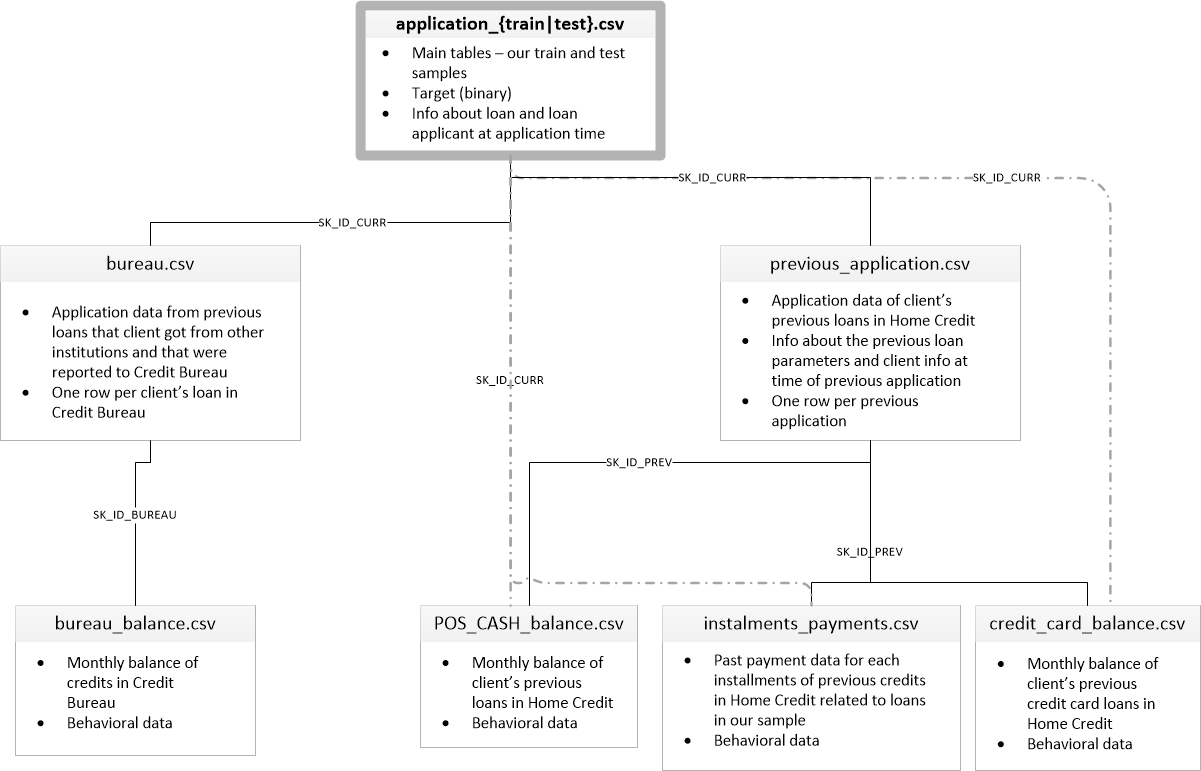

In [1]:
from IPython.display import Image
Image('media/home_credit.png')

## Objective
Develop a classification model to predict the value of the `TARGET` variable. A value of **1** indicates that the client had difficulties with payments (defaulted), while 0 indicates all other cases.

The performance metric for this study is **area under the ROC curve** between the predicted probability and the observed target.

## Summary
The study performed the following:
* Dealt with missing data by removing some features and keeping others
* Created new features based on domain knowledge
* Performed feature selection based on an ensemble of models' feature importance scores
* Trained four models: `XGBoost`, `LightGBM`, `CatBoostClassifier` and `BalancedRandomForestClassifier`, all four of which support missing data
* Tuned models using `Optuna`
* Created a `VotingClassifier` ensemble with optimal model weights
* Selected the tuned `LightGBM` model as the deployment model, with a test score of **0.76221**
* Deployed the model to Google Cloud Services

# Data Preparation
## Modules, Functions Import & Configuration

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from IPython.display import HTML
import optuna
import logging
import re
import joblib
import time

from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

# Data Processing
from utils import train_test_missing_values, check_duplicates, exclude_list_value, create_features
from utils import encoding_step, transform_and_scaling_step

# Feature Engineering and Selection
from utils import calculate_class_weights, phik_matrix, ensemble_feature_importance
from utils import check_feature_importance_correlation, plot_feature_importance

# Model Evaluation
from utils import calculate_roc_auc_score, negative_auc_roc, numerical_predictor_significance_test
from utils import categorical_predictor_significance_test, interpret_results_numerical, interpret_results_categorical

# Visualization
from utils import visualize_performance, plot_probability_distribution
from utils import draw_predictor_numerical_plots, draw_predictor_categorical_plots

# Additional utility
from utils import export_predictions, custom_format, get_screen_width, set_font_size, COLOR_PALETTE

In [3]:
# Suppress Warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

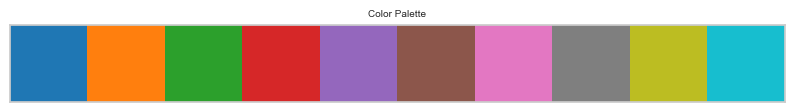

In [4]:
# Seed & Visualization parameters
RANDOM_STATE = 98
fig_width = get_screen_width() / 100
font_sizes = set_font_size()
plt.rcParams.update(font_sizes)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = custom_format
pd.set_option('display.max_rows', None)
HTML('<style>{}</style>'.format(open('styles.css').read()))

# Color style
color_palette = COLOR_PALETTE
sns.set_theme(font_scale=0.6)
sns.set_palette(color_palette)
sns.set_style('whitegrid', {'axes.grid' : False})
sns.palplot(color_palette)
plt.title('Color Palette')
plt.show()

## Dataset Import

In [5]:
DATA_PATH = 'data'
df_train = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'))
df_test = pd.read_csv(os.path.join(DATA_PATH, 'application_test.csv'))

In [6]:
df_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500,406597.50,24700.50,...,0,0,0,0,0,0,0,0,0,1
1,100003,0,Cash loans,F,N,N,0,270000,1293502.50,35698.50,...,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500,135000,6750,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000,312682.50,29686.50,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500,513000,21865.50,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print(f"Dataset size: {df_train.shape[0]+df_test.shape[0]} rows, {df_train.shape[1]} columns")
print(f"Train size:" , df_train.shape, "Test size:" , df_test.shape)

Dataset size: 356255 rows, 122 columns
Train size: (307511, 122) Test size: (48744, 121)


<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>For memory management, only train and test datasets were loaded. Other supporting datasets will be loaded during feature engineering.</ul>
        <ul>Dataset contains 350,000+ rows</ul>
        <ul>Roughly 87%-13% train-test split</ul>
        <ul>121 features, binary label</code></ul>
    </ol>
</div>

# Data Formatting & Cleaning

## Correct
* Check for duplicates, remove if necessary.
* Check statistical summaries, remove errors.

In [8]:
check_duplicates(df_train.drop('SK_ID_CURR', axis=1), "Train")
check_duplicates(df_test, "Test")

DataFrame: Train
Total rows: 307511
Duplicate rows: 0

DataFrame: Test
Total rows: 48744
Duplicate rows: 0



### Statistical Summary - Numerical Columns

In [9]:
numerical_columns = df_train.select_dtypes(exclude=['object']).columns
round(df_train[numerical_columns].describe(), 2).T

,count,mean,std,min,25%,50%,75%,max
SK_ID_CURR,307511,278180.52,102790.18,100002,189145.50,278202,367142.50,456255
TARGET,307511,0.08,0.27,0,0,0,0,1
CNT_CHILDREN,307511,0.42,0.72,0,0,0,1,19
AMT_INCOME_TOTAL,307511,168797.92,237123.15,25650,112500,147150,202500,117000000
AMT_CREDIT,307511,599026,402490.78,45000,270000,513531,808650,4050000
AMT_ANNUITY,307499,27108.57,14493.74,1615.50,16524,24903,34596,258025.50
AMT_GOODS_PRICE,307233,538396.21,369446.46,40500,238500,450000,679500,4050000
REGION_POPULATION_RELATIVE,307511,0.02,0.01,0,0.01,0.02,0.03,0.07
DAYS_BIRTH,307511,-16037,4363.99,-25229,-19682,-15750,-12413,-7489
DAYS_EMPLOYED,307511,63815.05,141275.77,-17912,-2760,-1213,-289,365243


<div class="next-steps">
    <h3>Observations</h3>
    <p>Numerical Columns</p>
    <ol>
        <ul><code>DAYS_EMPLOYED</code> seems to have errors, as indicated by the value of <b>365243</b>, which is 1000+ years</ul>
        <ul>Other features don't have observable errors, but outliers are present</ul>
    </ol>
</div>

In [10]:
df_train.loc[df_train['DAYS_EMPLOYED'] > 100*365, 'DAYS_EMPLOYED'] = np.nan

### Statistical Summary - Categorical Columns

In [11]:
categorical_columns = df_train.select_dtypes(include=['object']).columns
round(df_train[categorical_columns].describe(), 2).T

,count,unique,top,freq
NAME_CONTRACT_TYPE,307511,2,Cash loans,278232
CODE_GENDER,307511,3,F,202448
FLAG_OWN_CAR,307511,2,N,202924
FLAG_OWN_REALTY,307511,2,Y,213312
NAME_TYPE_SUITE,306219,7,Unaccompanied,248526
NAME_INCOME_TYPE,307511,8,Working,158774
NAME_EDUCATION_TYPE,307511,5,Secondary / secondary special,218391
NAME_FAMILY_STATUS,307511,6,Married,196432
NAME_HOUSING_TYPE,307511,6,House / apartment,272868
OCCUPATION_TYPE,211120,18,Laborers,55186


In [12]:
categorical_summary = []
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        unique_values = df_train[col].unique()
        categorical_summary.append({
            'Column': col,
            'Unique Values Count': len(unique_values),
            'Unique Values': unique_values
        })
pd.DataFrame(categorical_summary)

,Column,Unique Values Count,Unique Values
0,NAME_CONTRACT_TYPE,2,"[Cash loans, Revolving loans]"
1,CODE_GENDER,3,"[M, F, XNA]"
2,FLAG_OWN_CAR,2,"[N, Y]"
3,FLAG_OWN_REALTY,2,"[Y, N]"
4,NAME_TYPE_SUITE,8,"[Unaccompanied, Family, Spouse, partner, Children, Other_A, nan, Other_B, Group of people]"
5,NAME_INCOME_TYPE,8,"[Working, State servant, Commercial associate, Pensioner, Unemployed, Student, Businessman, Maternity leave]"
6,NAME_EDUCATION_TYPE,5,"[Secondary / secondary special, Higher education, Incomplete higher, Lower secondary, Academic degree]"
7,NAME_FAMILY_STATUS,6,"[Single / not married, Married, Civil marriage, Widow, Separated, Unknown]"
8,NAME_HOUSING_TYPE,6,"[House / apartment, Rented apartment, With parents, Municipal apartment, Office apartment, Co-op apartment]"
9,OCCUPATION_TYPE,19,"[Laborers, Core staff, Accountants, Managers, nan, Drivers, Sales staff, Cleaning staff, Cooking staff, Private service staff, Medicine staff, Security staff, High skill tech staff, Waiters/barmen staff, Low-skill Laborers, Realty agents, Secretaries, IT staff, HR staff]"


<div class="next-steps">
    <h3>Observations</h3>
    <p>Categorical Columns` granularity</p>
    <ol>
        <ul>Most columns have low granularity under 10 unique values; One-hot-encoding for these columns is suitable.</ul>
        <ul>Two features <code>OCCUPATION_TYPE</code> and <code>ORGANIZATION_TYPE</code> have high granularity; Mean encoding is a better choice.</ul>
        <ul>No typos observed - values replacement not needed.</ul>
    </ol>
</div>

## Complete
Deal with missing values in the dataset.

In [13]:
missing_values = train_test_missing_values(df_train, df_test, missing_only=True)
missing_values

,Data Type,Train #,Train %,Test #,Test %
COMMONAREA_MODE,float64,214865,69.90,33495,68.70
COMMONAREA_MEDI,float64,214865,69.90,33495,68.70
COMMONAREA_AVG,float64,214865,69.90,33495,68.70
NONLIVINGAPARTMENTS_AVG,float64,213514,69.40,33347,68.40
NONLIVINGAPARTMENTS_MEDI,float64,213514,69.40,33347,68.40
NONLIVINGAPARTMENTS_MODE,float64,213514,69.40,33347,68.40
LIVINGAPARTMENTS_MEDI,float64,210199,68.40,32780,67.20
LIVINGAPARTMENTS_MODE,float64,210199,68.40,32780,67.20
FONDKAPREMONT_MODE,object,210295,68.40,32797,67.30
LIVINGAPARTMENTS_AVG,float64,210199,68.40,32780,67.20


In [14]:
print(f"Number of features with missing values: {missing_values.shape[0]} "
    f"({round(missing_values.shape[0]/len(df_train.columns)*100, 2)}%)")

Number of features with missing values: 68 (55.74%)


More than half of features are missing values. Based on initial observation, we can cluster the missing features into the following groups:
1. Building Information. These features are related to the building where the client lives. The high percentage of missing values could be due to
* Incomplete records from housing authorities or real estate databases.
* Clients living in areas where detailed building information is not readily available.
* Privacy concerns leading to non-disclosure of specific building details.
* Difficulty in obtaining accurate historical data for older buildings.
**Decision** - identify whether any of the features are intercorrelated (e.g., MODE/MEDI/AVG) and remove them.

2. External source cluster `EXT_SOURCE_` features. They represent normalized scores from external data sources. **Data missingness varies by source**. The missing values could be due to:
* Clients not present in certain external databases.
**Decision** - keep the features if they show importance in predicting the target.

3. Credit Bureau Inquiry `AMT_REQ_CREDIT_BUREAU_YEAR/WEEK/QRT/MON/HOUR/DAY` features. They represent the number of inquiries to Credit Bureau about the client in different time frames. **13.5% of data missing**. The missing values could be due to:
* No credit bureau inquiries made for some clients.
* Incomplete records from the credit bureau.
* Customers with no credit history.
**Decision** - identify whether any of the features are intercorrelated or provide importance in predicting the target. If not, remove them.

4. Social Circle Default Observation features `OBS_30_CNT_SOCIAL_CIRCLE`, `OBS_60_CNT_SOCIAL_CIRCLE`, `DEF_30_CNT_SOCIAL_CIRCLE`, `DEF_60_CNT_SOCIAL_CIRCLE`. **0.3% of data missing**. The missing values could be due to:
* Incomplete social network data
* Privacy settings preventing access
* New clients with limited social circle data
**Decision** - identify whether any of the features are intercorrelated or provide importance in predicting the target. If not, remove them or the rows that are missing them.

5. Employment Information: `DAYS_EMPLOYED`, `OCCUPATION_TYPE`. **Data missingness is 18.3% and 31.3% respectively**. The missing values could be due to:
* Unemployed or non-traditional employment.
* Clients not disclosing their occupation or employment history.
* Recent graduates or individuals new to the workforce.
**Decision** - create missingness indication for `OCCUPATION_TYPE`. Keep the features.

In [15]:
def occupation_type_fix(df):
    df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')
    df['OCCUPATION_TYPE_missing'] = df['OCCUPATION_TYPE'].isnull().astype(int)

occupation_type_fix(df_train)
occupation_type_fix(df_test)

<div class="next-steps">
    <h3>Observations</h3>
    <p>Missing values</p>
    <ol>
        <ul>No <code>int64</code> features are missing values</ul>
        <ul>A lot of features with more than 50% of missing values</ul>
        <ul>A lot of the missing features have AVG, MEDI and MODE expressions</ul>
        <ul>67 features are missing at least one value<ul>
    </ol>
</div>

Let's view feature importances for the missing features. We will do the following:
* Categorize the features with missing values based on the missing percentages
* Calculate feature importances using `XGBoost` and `LightGBM` built-in feature importance functions
* Visualize the missing features and their importances to the models

In [16]:
missing_values['Category'] = 'Low'
missing_values.loc[(missing_values['Train %'] > 10) | (missing_values['Test %'] > 10), 'Category'] = 'Medium'
missing_values.loc[(missing_values['Train %'] > 50) | (missing_values['Test %'] > 50), 'Category'] = 'High'

In [17]:
y_train = df_train['TARGET']
class_weights, weights_array, weight_ratio = calculate_class_weights(y_train)
feature_importances = ensemble_feature_importance(df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1),
                                                    y_train, n_iterations=5)

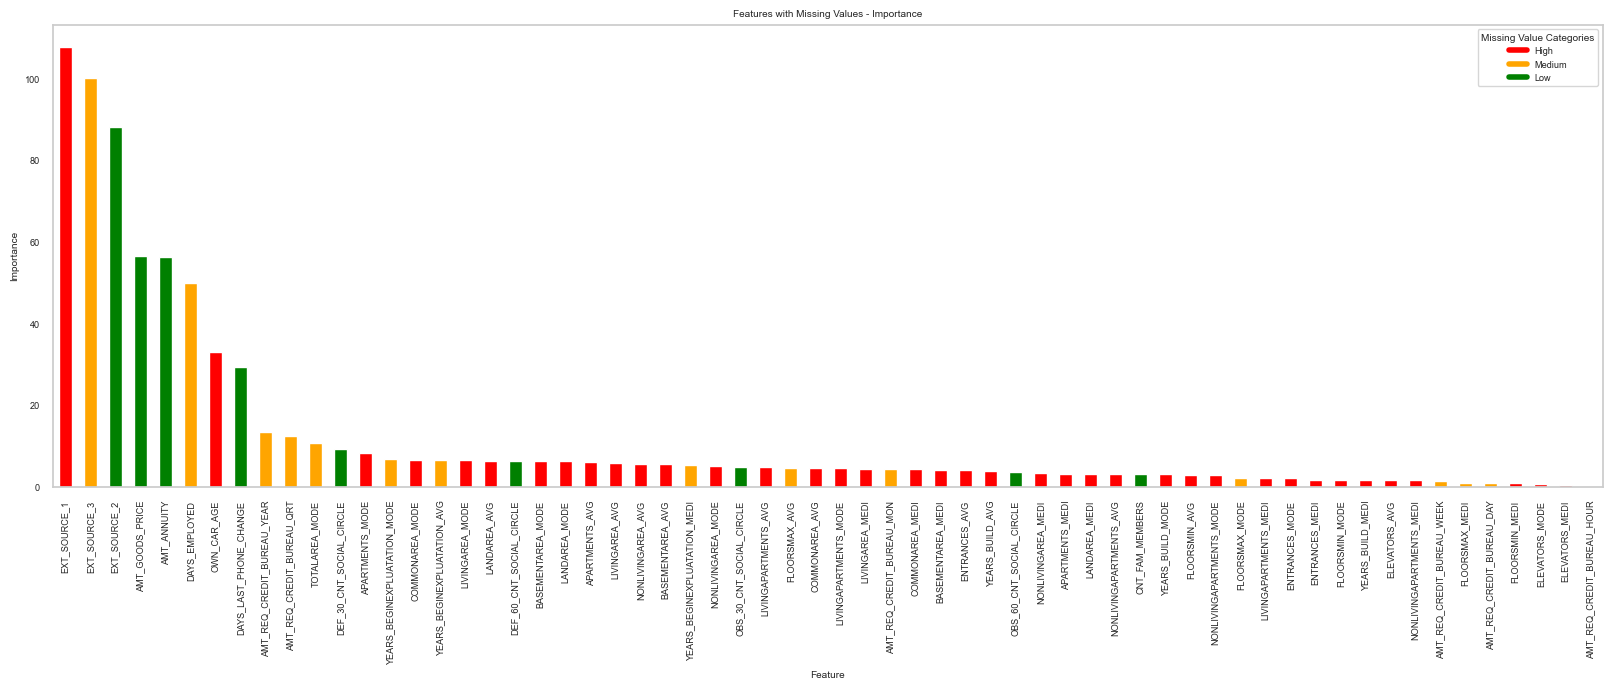

In [18]:
category_colors = {
    'High': 'red',
    'Medium': 'orange',
    'Low': 'green'
}
features_with_missing = missing_values[missing_values['Data Type'] != 'object'].index
missing_values_importances = feature_importances[feature_importances.index.isin(features_with_missing)]
plot_data = missing_values.loc[features_with_missing]
plot_data['Importance'] = missing_values_importances
plot_data = plot_data.sort_values(by='Importance', ascending=False)
colors = plot_data['Category'].map(category_colors)

plt.figure(figsize=(20, 6))
ax = plot_data['Importance'].plot.bar(title="Features with Missing Values - Importance", color=colors)
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in category_colors.values()]
labels = category_colors.keys()
ax.legend(handles, labels, title="Missing Value Categories")

plt.show()

In [19]:
building_info_columns = [
    'ELEVATORS_MEDI', 'ELEVATORS_MODE', 'ELEVATORS_AVG',
    'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 'FLOORSMIN_AVG',
    'FLOORSMAX_MEDI', 'FLOORSMAX_MODE', 'FLOORSMAX_AVG',
    'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'ENTRANCES_AVG',
    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
    'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG',
    'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'LIVINGAREA_AVG',
    'APARTMENTS_MEDI', 'APARTMENTS_MODE', 'APARTMENTS_AVG',
    'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI',
    'COMMONAREA_AVG', 'COMMONAREA_MODE', 'COMMONAREA_MEDI',
    'LANDAREA_AVG', 'LANDAREA_MODE', 'LANDAREA_MEDI',
    'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MODE', 'NONLIVINGAREA_MEDI',
]

def get_building_features_to_remove(feature_importances, building_info_columns):
    feature_groups = {}
    for feature in building_info_columns:
        base_name = re.sub(r'_(AVG|MODE|MEDI)$', '', feature)
        if base_name not in feature_groups:
            feature_groups[base_name] = []
        feature_groups[base_name].append(feature)
    
    features_to_remove = []
    
    for base_name, variants in feature_groups.items():
        if len(variants) > 1:
            best_variant = max(variants, key=lambda x: feature_importances.get(x, 0))
            features_to_remove.extend([v for v in variants if v != best_variant])
    
    return features_to_remove

cols_remove = get_building_features_to_remove(feature_importances, building_info_columns)
df_train = df_train.drop(cols_remove, axis=1)
df_test = df_test.drop(cols_remove, axis=1)

In [20]:
cols_remove = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK']
df_train = df_train.drop(cols_remove, axis=1)
df_test = df_test.drop(cols_remove, axis=1)

Additionally, let's look at the top feature interactions (Phik Coefficient > 0.8) and see whether there are any features that might result in multicollinearity and should be removed.

In [21]:
corr_matrix = df_train.drop(['TARGET', 'SK_ID_CURR'], axis=1).phik_matrix(interval_cols=numerical_columns)
corr_df = corr_matrix.unstack().reset_index()
corr_df.columns = ['Feature1', 'Feature2', 'Phik Coefficient']
corr_df = corr_df[corr_df['Feature1'] < corr_df['Feature2']]
top_interactions = corr_df[corr_df['Phik Coefficient'] > 0.8].sort_values('Phik Coefficient', ascending=False)

if isinstance(feature_importances, pd.DataFrame) and len(feature_importances.columns) == 1:
    feature_importances = feature_importances.iloc[:, 0]
def _get_importance(feature):
    return feature_importances.get(feature, 0)
top_interactions['Feature1 Score'] = top_interactions['Feature1'].apply(_get_importance)
top_interactions['Feature2 Score'] = top_interactions['Feature2'].apply(_get_importance)

top_interactions

,Feature1,Feature2,Phik Coefficient,Feature1 Score,Feature2 Score
1879,FLAG_EMP_PHONE,NAME_INCOME_TYPE,1,0,3.30
1907,FLAG_EMP_PHONE,ORGANIZATION_TYPE,1,0,307.71
5492,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,1,4.70,3.70
2521,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,1.00,1.40,10.81
542,AMT_CREDIT,AMT_GOODS_PRICE,0.98,73.81,56.51
383,CNT_CHILDREN,CNT_FAM_MEMBERS,0.98,1.30,3.20
3059,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,0.98,0.30,0.10
3329,LIVE_CITY_NOT_WORK_CITY,REG_CITY_NOT_WORK_CITY,0.96,0.60,0.20
4587,APARTMENTS_MODE,LIVINGAPARTMENTS_AVG,0.96,8.20,4.70
5582,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,0.94,9.21,6.21


In [22]:
cols_remove = ['FLAG_EMP_PHONE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'REGION_RATING_CLIENT', 'CNT_CHILDREN',
            'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_WORK_CITY', 'DEF_60_CNT_SOCIAL_CIRCLE',
            ]

df_train = df_train.drop(cols_remove, axis=1)
df_test = df_test.drop(cols_remove, axis=1)

In [23]:
print(f"Train data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Train data shape: (307511, 85)
Test data shape: (48744, 84)


<div class="next-steps">
    <h3>Observations</h3>
    <p>Missing values</p>
    <ol>
        <ul>A decent size of features with missing values have low feature importance</ul>
        <ul>Features with lower missing values rates have a relatively higher feature importance</ul>
        <ul>Least important variants of the same metric were removed</ul>
        <ul>Features with zero or near-zero importance were removed</ul>
        <ul>36 features were removed</ul>
    </ol>
</div>

## Create
Create additional features based on provided dataset context to improve EDA.

We will load the supplementary datasets and create the following **22** features:
1. Initial Dataset
   * **Debt-to-Income Ratio**: Using `AMT_INCOME_TOTAL` and `AMT_CREDIT`, gives a crucial indicator of a person's ability to manage monthly payments
   * **Payment-to-Income Ratio**: Using `AMT_ANNUITY` and `AMT_INCOME_TOTAL`, calculate how much of a person's income goes towards loan payments
   * **Employment Stability**: Create employment categories based on `DAYS_EMPLOYED`
   * **Age Group**: Create age groups based on `DAYS_BIRTH`
   * **Recent Inquiry Intensity**: Sum of `AMT_REQ_CREDIT_BUREAU_*` fields. Many recent inquiries might indicate desperation for credit
   * **Asset Ownership Score**: Combine `FLAG_OWN_CAR` and `FLAG_OWN_REALTY`. Owning assets might indicate financial stability
   * **Social Circle Default Rate**: Calculate (`DEF_30_CNT_SOCIAL_CIRCLE` / `OBS_30_CNT_SOCIAL_CIRCLE`). High default rates in social circle might indicate higher risk
   * **Income to Credit Limit Ratio**: Calculate `AMT_INCOME_TOTAL` / `AMT_CREDIT_LIMIT_ACTUAL`; This could indicate how banks perceive the client's creditworthiness
   * **Occupation Risk Score**: Create a risk score for each `OCCUPATION_TYPE` based on historical default rates
   * **Region Risk Score**: Similar to occupation, create a risk score using `REGION_RATING_CLIENT` based on historical default rates
   * **Loan to Value Ratio** (for secured loans): Calculate (`AMT_CREDIT` / `AMT_GOODS_PRICE`) to get the ratio of the loan relative to the asset value
   * **Behavioral Score**: Combine behavioral indicators (payment history, credit utilization, etc.) into a single score
2. Credit Card Balance Dataset
   * **Credit Utilization Rate**: For credit card data, calculate (`AMT_BALANCE` / `AMT_CREDIT_LIMIT_ACTUAL`). High utilization often correlates with higher risk
   * **Credit Card Spending Behavior**: From *credit_card_balance.csv*, calculate average utilization and payment ratios. Responsible credit card use can be a positive indicator
3. Bureau Dataset
   * **Credit History Length**: Calculate using the earliest `DAYS_CREDIT`; Longer credit history can be a positive factor, familiarity with credits
4. Previous Applications Dataset
   * **Loan Application Frequency**: Count the number of previous applications of the client. Frequent applications might indicate financial distress
   * **Cash Loan Proportion**: Calculate the proportion of cash loans to total loans; A high proportion of cash loans might indicate liquidity issues
5. Installments Payments Dataset
   * **Payment Timeliness**: Calculate the average delay in payments (`DAYS_ENTRY_PAYMENT` - `DAYS_INSTALMENT`). Consistent late payments are a risk
6. POS Cash Balance Dataset
   * **Average Days Past Due (DPD) Ratio**: Average ratio of payments that were due. Clients with higher ratios are riskier.
   * **Future Installment Trend**: Calculate the trend in the number of future installments. Negative trends indicate that the client is paying off debts.
7. Bureau Balance Dataset
   * **Active Loans Ratio**: Ratio of active loans for a client. A higher ratio indicates that the client keeps more active loans over time.



In [24]:
df_bureau_balance = pd.read_csv(os.path.join(DATA_PATH, 'bureau_balance.csv'))
df_bureau = pd.read_csv(os.path.join(DATA_PATH, 'bureau.csv'))
df_cc_balance = pd.read_csv(os.path.join(DATA_PATH, 'credit_card_balance.csv'))
df_installments_payments = pd.read_csv(os.path.join(DATA_PATH, 'installments_payments.csv'))
df_pos_cash_balance = pd.read_csv(os.path.join(DATA_PATH, 'POS_CASH_balance.csv'))
df_previous_application = pd.read_csv(os.path.join(DATA_PATH, 'previous_application.csv'))

In [25]:
df_train = create_features(df_train, df_bureau_balance, df_bureau, df_cc_balance, df_installments_payments,
                        df_pos_cash_balance, df_previous_application, is_train=True)
df_test = create_features(df_test, df_bureau_balance, df_bureau, df_cc_balance, df_installments_payments,
                        df_pos_cash_balance, df_previous_application, is_train=False)

del df_bureau_balance, df_bureau, df_cc_balance, 
del df_installments_payments, df_pos_cash_balance, df_previous_application

Before we proceed, let's align both train and test datasets by making sure that both datasets contain the same features.

In [26]:
train_labels = df_train['TARGET']
df_train, df_test = df_train.align(df_test, join='inner', axis=1)
df_train['TARGET'] = train_labels
print(f"Train data shape: {df_train.shape}")
print(f"Test data shape: {df_test.shape}")

Train data shape: (307511, 107)
Test data shape: (48744, 106)


## Convert
Review and change columns` datatypes, if necessary.

This step is not necessary. Prior numerical and categorical column summaries indicated that the columns are correctly classified.

# Exploratory Data Analysis
Let's explore the target variable and it's relationship to predictor variables.

## Target variable

In [27]:
target_col = 'TARGET'
value_counts = df_train[target_col].value_counts()
percentage_of_total = round((value_counts / value_counts.sum()) * 100, 2)
result = pd.DataFrame({
    'Value Counts': value_counts,
    'Percentage of Total (%)': percentage_of_total
})
result

,Value Counts,Percentage of Total (%)
TARGET,,
0,282686,91.93
1,24825,8.07


An imbalanced dataset, where only roughly 8% of the clients defaulted on their loans.

## Feature Correlations & Importance
Since the dataset has a lot of features, we will only explore target-feature relationships where the correlation is significant. We will select such features through **Mutual Information**.

In [28]:
df_train.dtypes.value_counts()
df_train = df_train.drop(columns=['SK_ID_CURR'])

In [29]:
feature_importances = check_feature_importance_correlation(df_train, 'TARGET')

In [30]:
df_feature_importances = pd.DataFrame({
    'Feature': feature_importances.index,
    'Importance': feature_importances.values,
}).sort_values(by='Importance', ascending=False)
df_feature_importances['Data Type'] = df_feature_importances['Feature'].map(df_train.dtypes)
df_feature_importances['Data Type'].fillna('object', inplace=True)

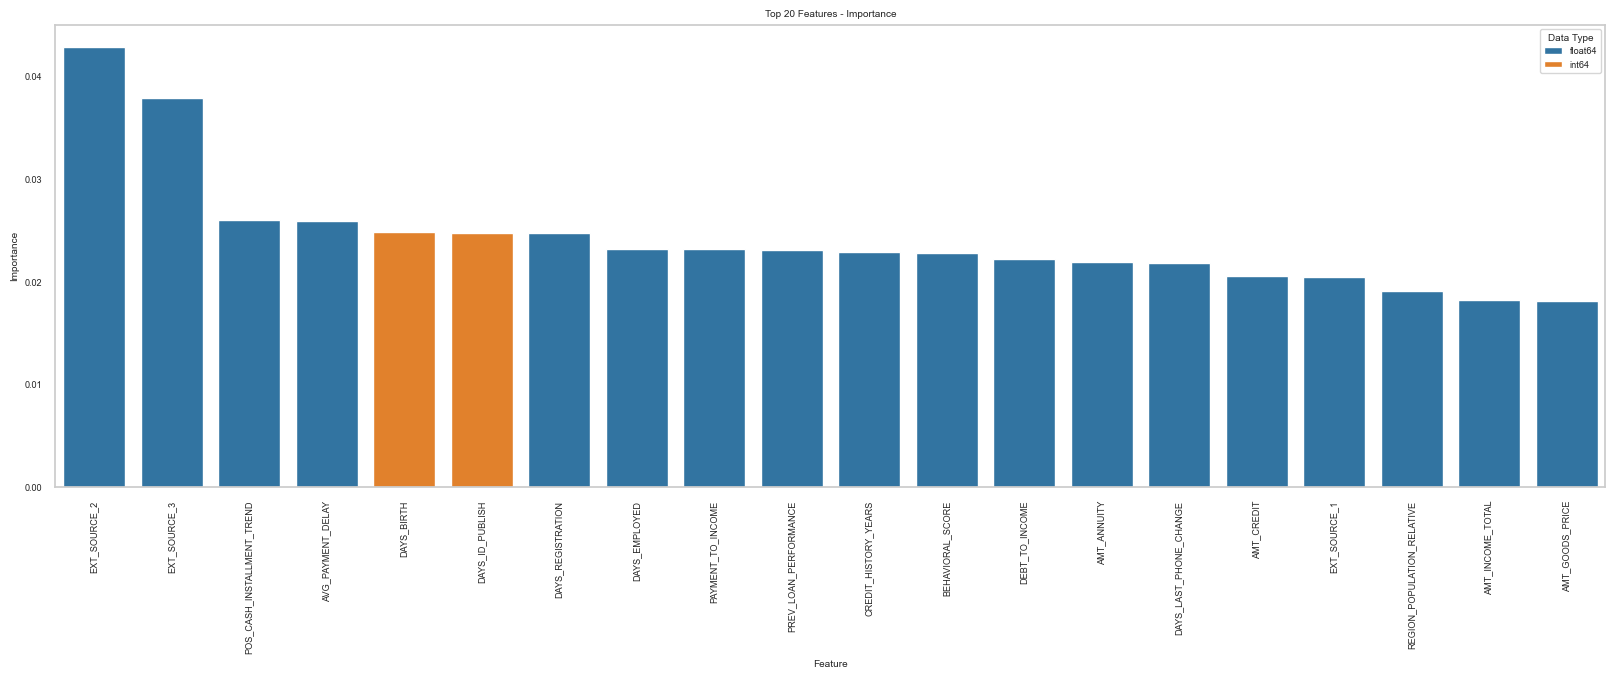

In [31]:
plt.figure(figsize=(20, 6))
ax = sns.barplot(data=df_feature_importances[:20], x='Feature', y='Importance', hue='Data Type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
ax.set_title("Top 20 Features - Importance")
plt.show()


<div class="next-steps">
    <h3>Observations</h3>
    <p>Feature Importance</p>
    <ol>
        <ul>Top 30 of Features deemed most important are numerical features</ul>
        <ul><code>EXT_SOURCE_</code> features, which indicate client credit ratings from a different party, seem to be most important</ul>
        <ul>Client age and days since ID change are the most important integer features</ul>
        <ul>Some newly created features, like <code>POS_CASH_INSTALLMENT_TREND</code> and <code>AVG_PAYMENT_DELAY</code> have made the list</ul>
    </ol>
</div>

We will explore the top 20 important features. None of the categorical features made the list, but they are few, so we will explore all of them.

## Numerical predictors
Let's explore the feature-target interactions through distributions. Statistical significance is expressed through two metrics:
* **p-value** - likelihood of null hypothesis (the feature makes two classes of clients different)
* **Effect Magnitude** - the practical significance of the difference

Feature: EXT_SOURCE_2. p-value: 0.0000. Effect size: 0.3122


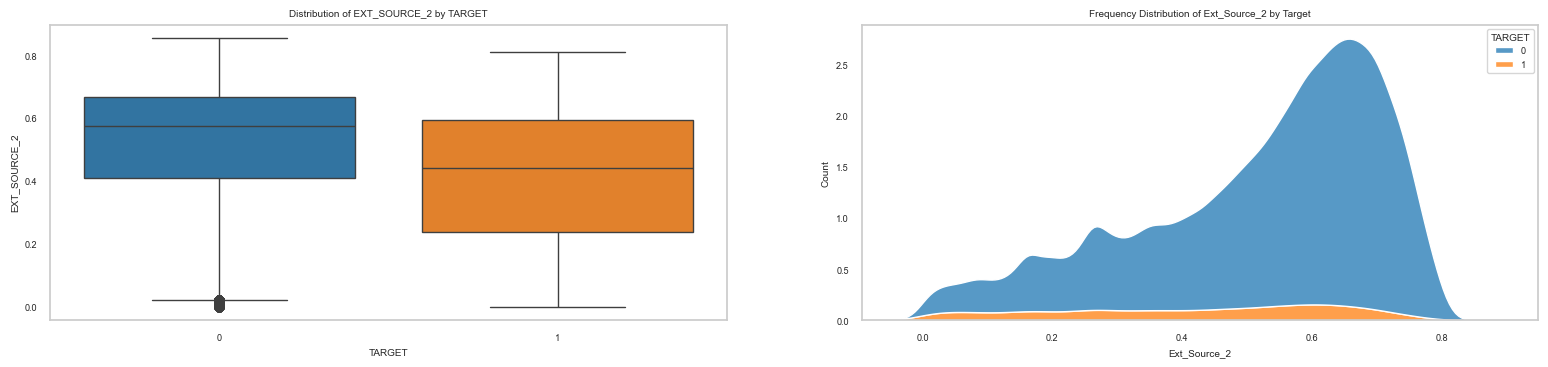

Feature: EXT_SOURCE_3. p-value: 0.0000. Effect size: 0.3588


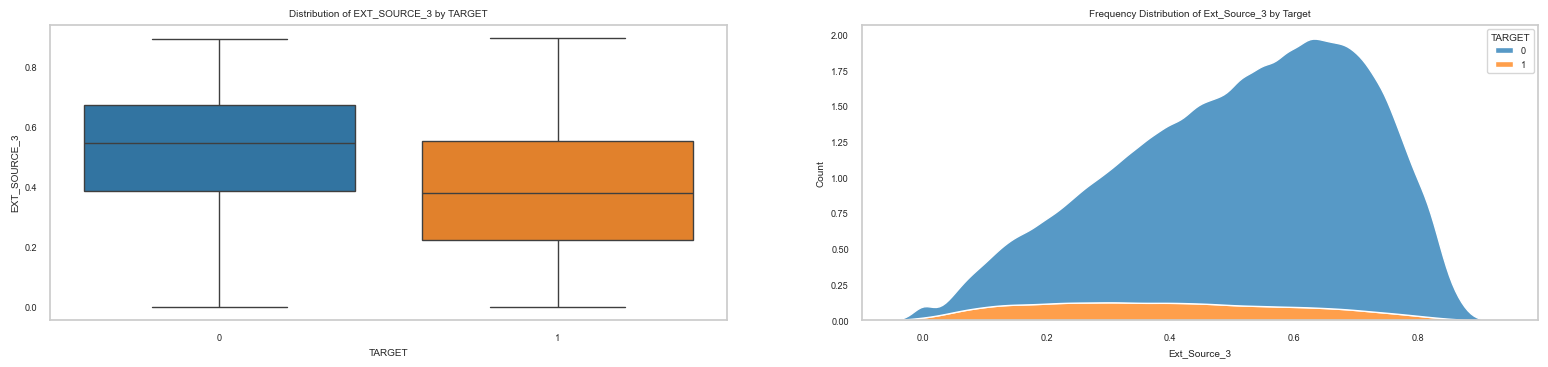

Feature: POS_CASH_INSTALLMENT_TREND. p-value: 0.0000. Effect size: 0.0437


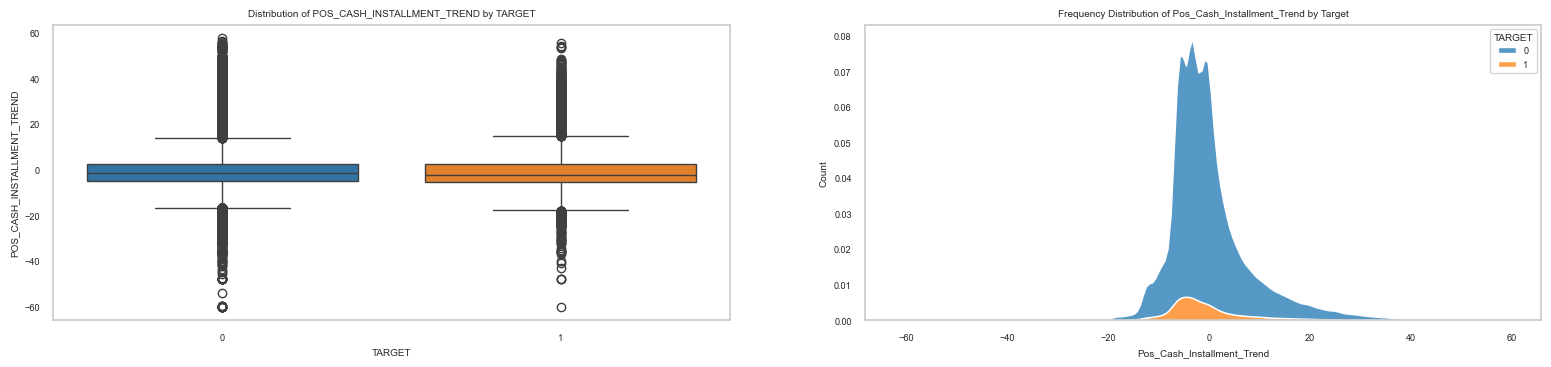

Feature: AVG_PAYMENT_DELAY. p-value: 0.0000. Effect size: -0.0853


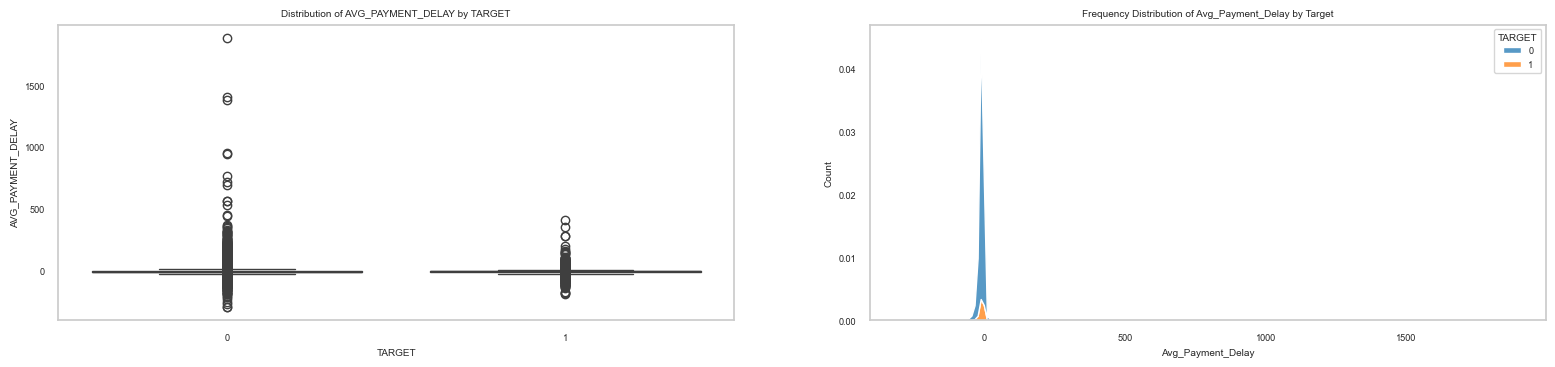

Feature: DAYS_BIRTH. p-value: 0.0000. Effect size: -0.1660


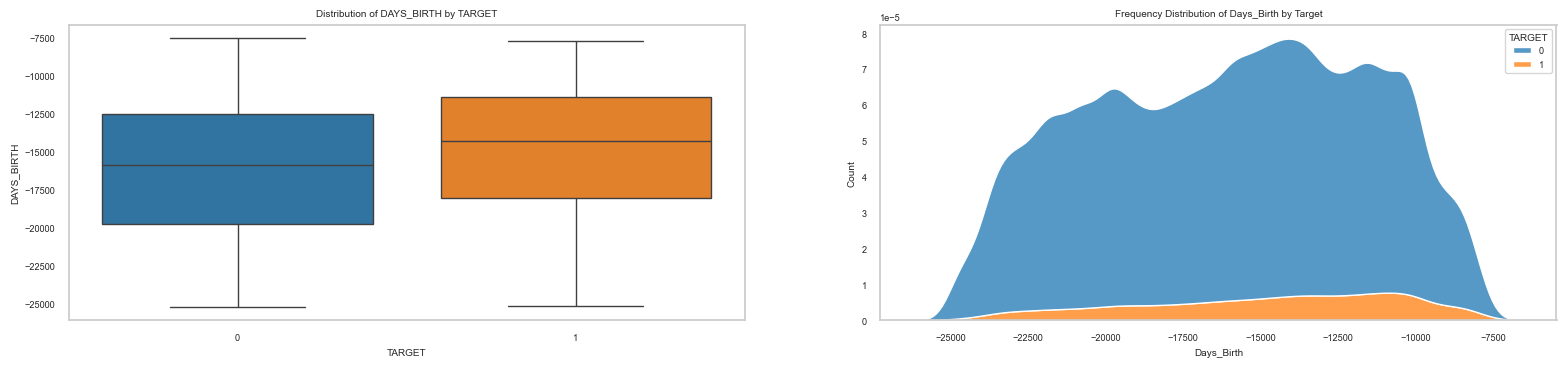

Feature: DAYS_ID_PUBLISH. p-value: 0.0000. Effect size: -0.1113


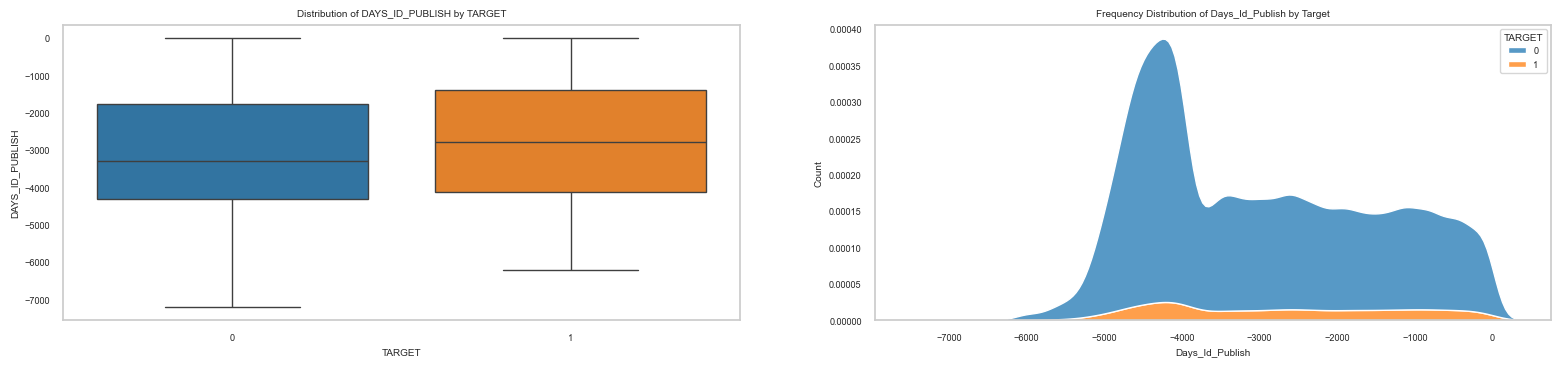

Feature: DAYS_REGISTRATION. p-value: 0.0000. Effect size: -0.0851


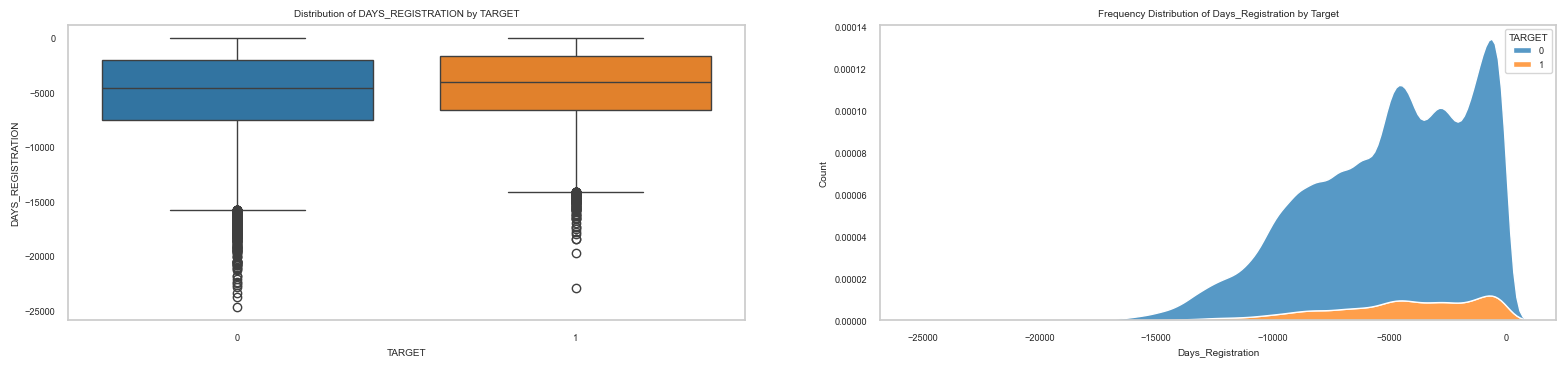

Feature: DAYS_EMPLOYED. p-value: 0.0000. Effect size: -0.1648


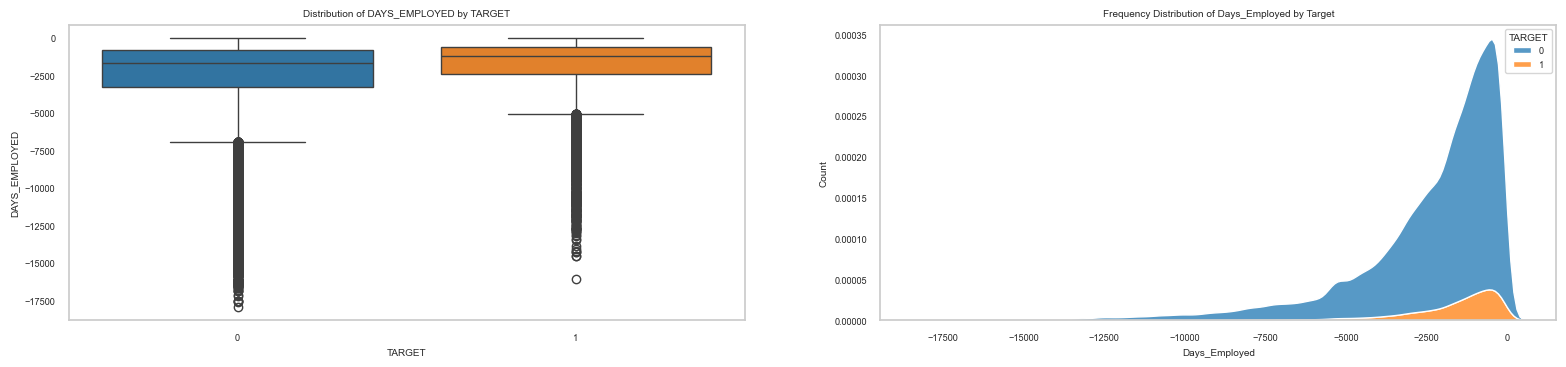

Feature: PAYMENT_TO_INCOME. p-value: 0.0000. Effect size: -0.0391


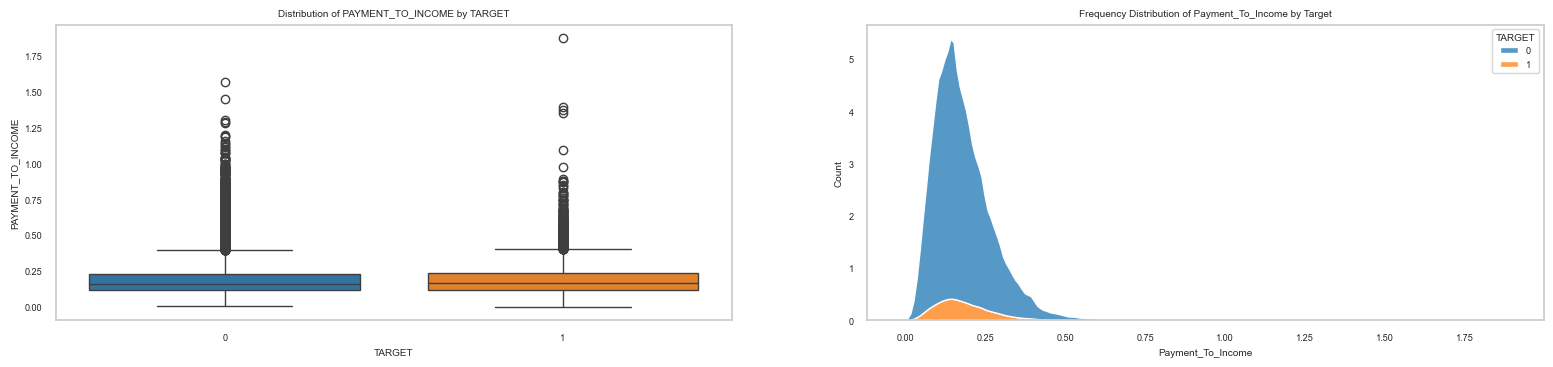

Feature: PREV_LOAN_PERFORMANCE. p-value: 0.0000. Effect size: 0.1993


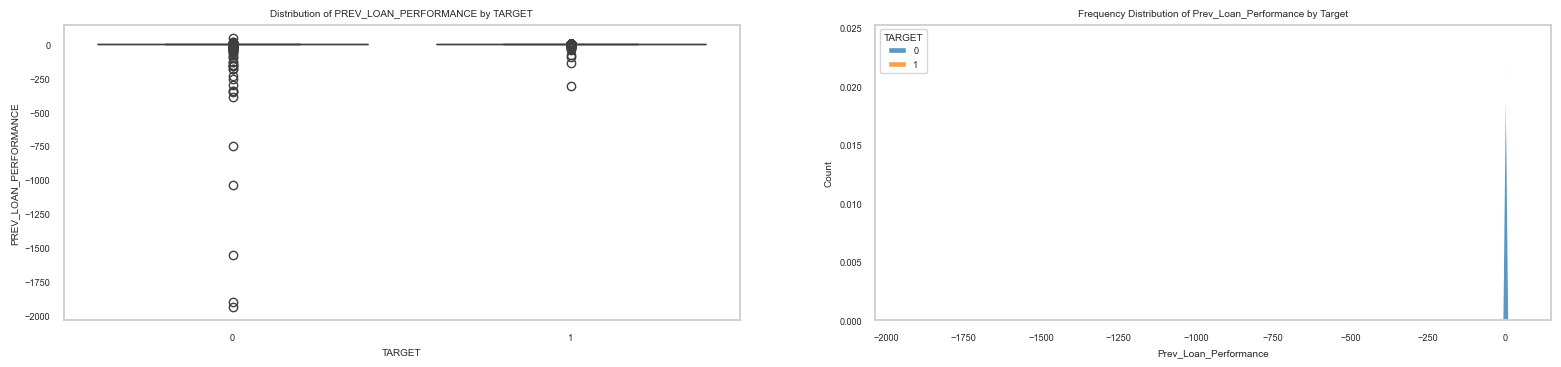

Feature: CREDIT_HISTORY_YEARS. p-value: 0.0000. Effect size: 0.1567


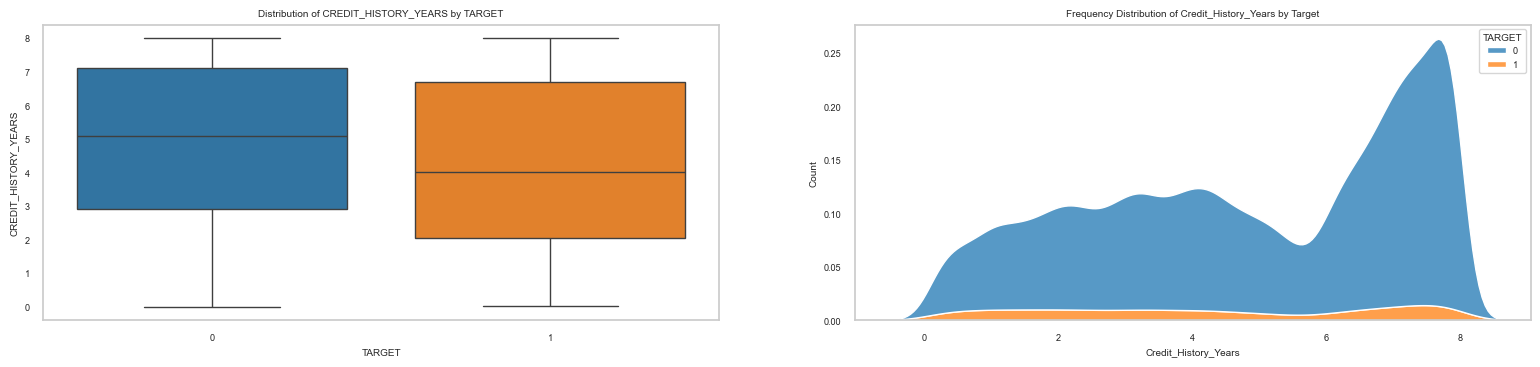

Feature: BEHAVIORAL_SCORE. p-value: 0.0000. Effect size: 0.0225


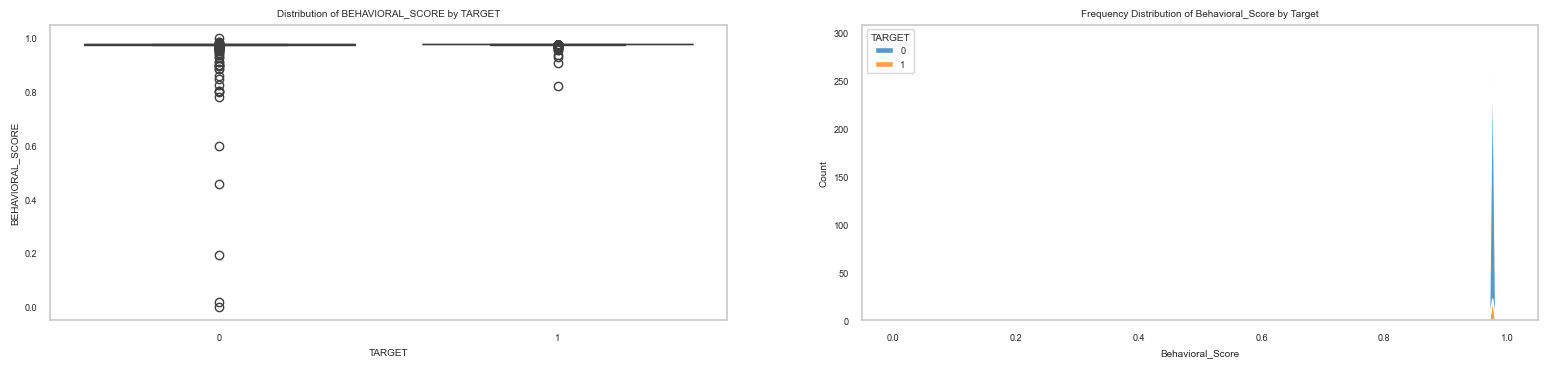

Feature: DEBT_TO_INCOME. p-value: 0.3188. Effect size: 0.0038


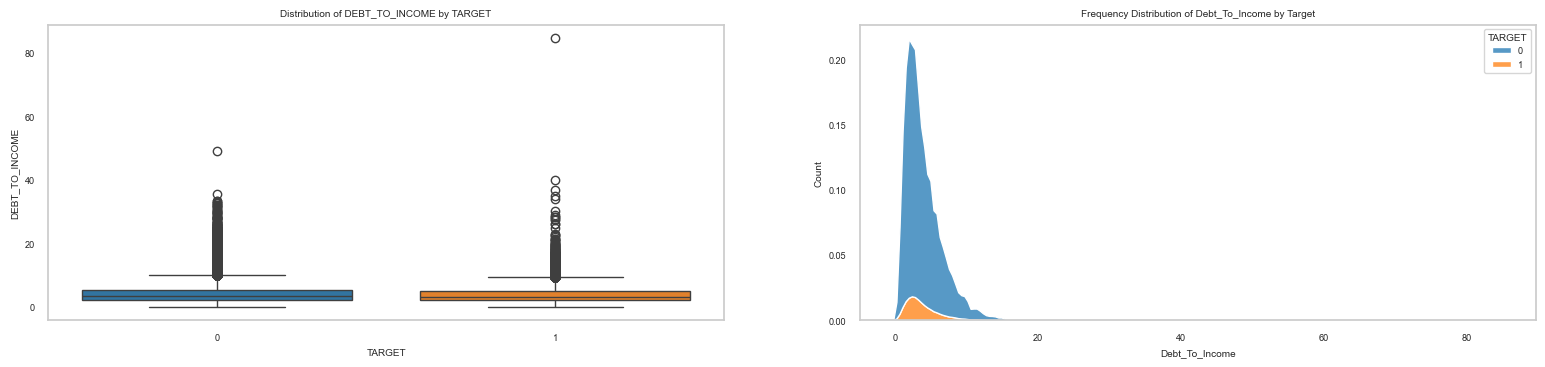

Feature: AMT_ANNUITY. p-value: 0.9676. Effect size: 0.0002


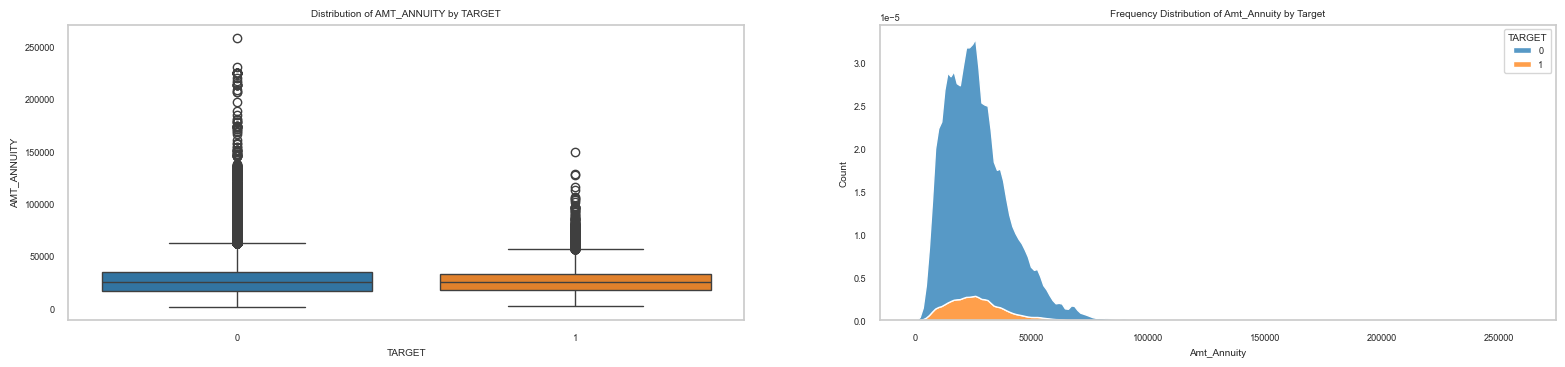

Feature: DAYS_LAST_PHONE_CHANGE. p-value: 0.0000. Effect size: -0.1137


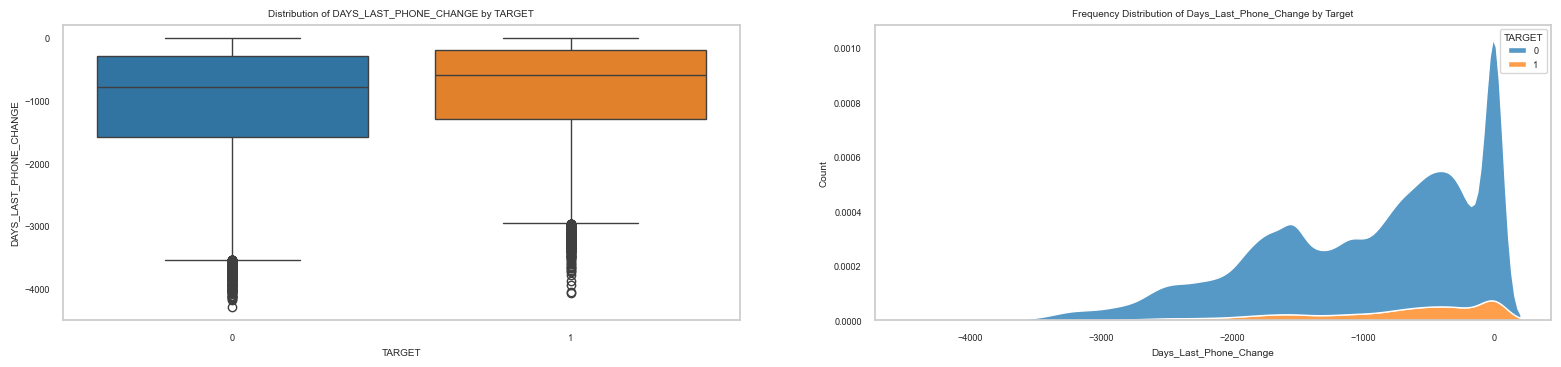

Feature: AMT_CREDIT. p-value: 0.0000. Effect size: 0.0372


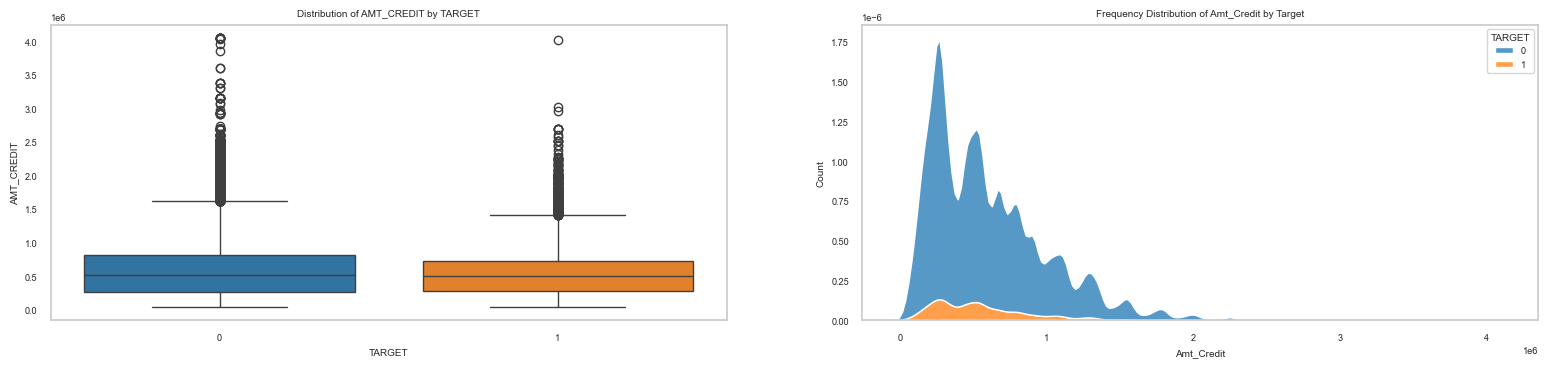

Feature: EXT_SOURCE_1. p-value: 0.0000. Effect size: 0.3314


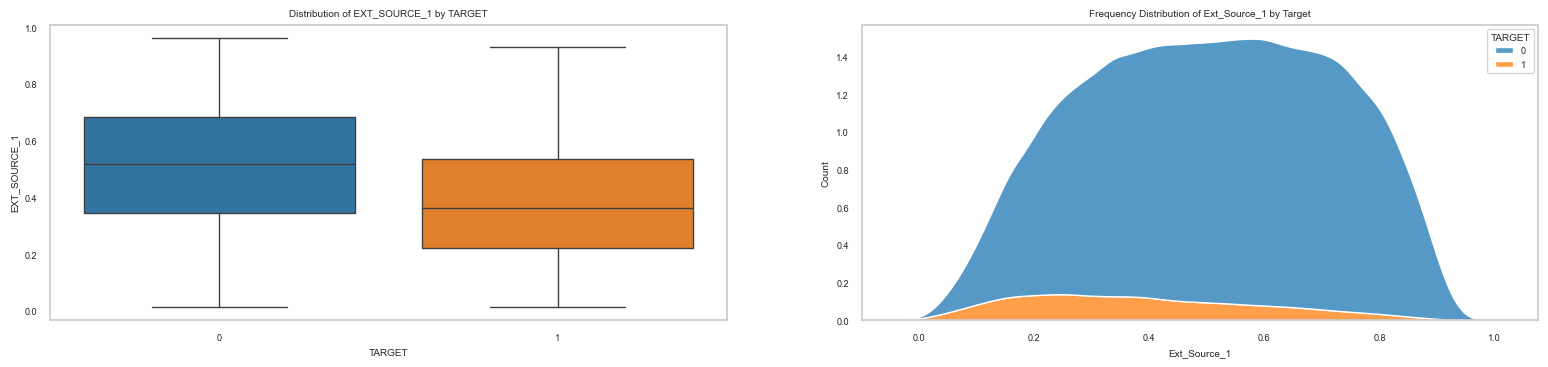

Feature: REGION_POPULATION_RELATIVE. p-value: 0.0000. Effect size: 0.0647


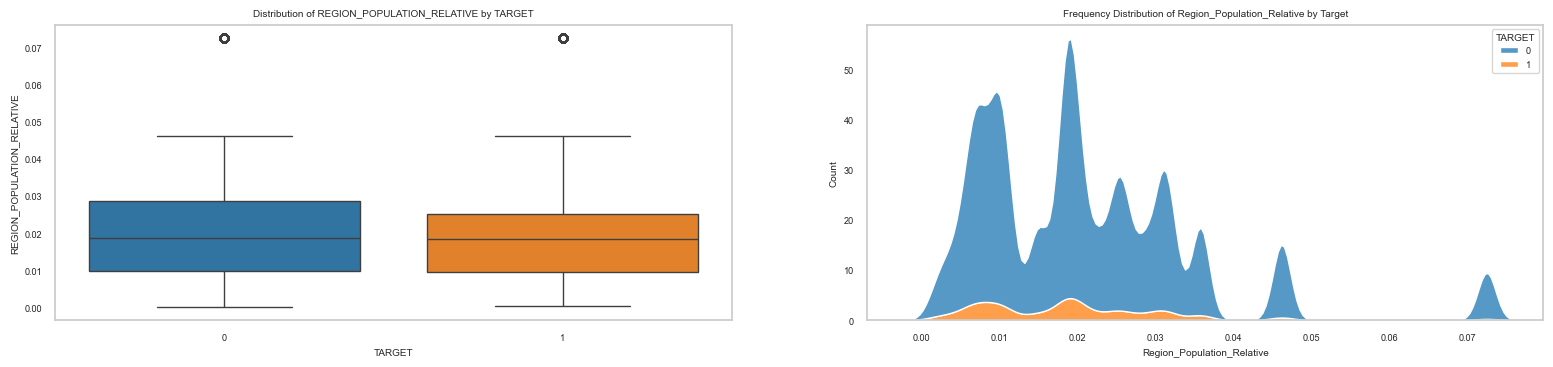

Feature: AMT_INCOME_TOTAL. p-value: 0.0000. Effect size: 0.0383


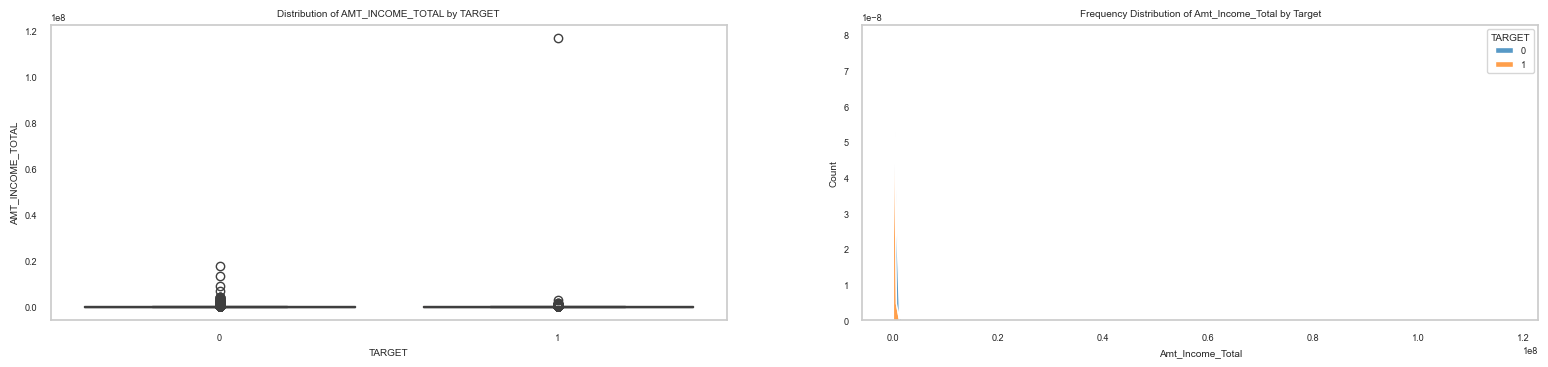

Feature: AMT_GOODS_PRICE. p-value: 0.0000. Effect size: 0.0667


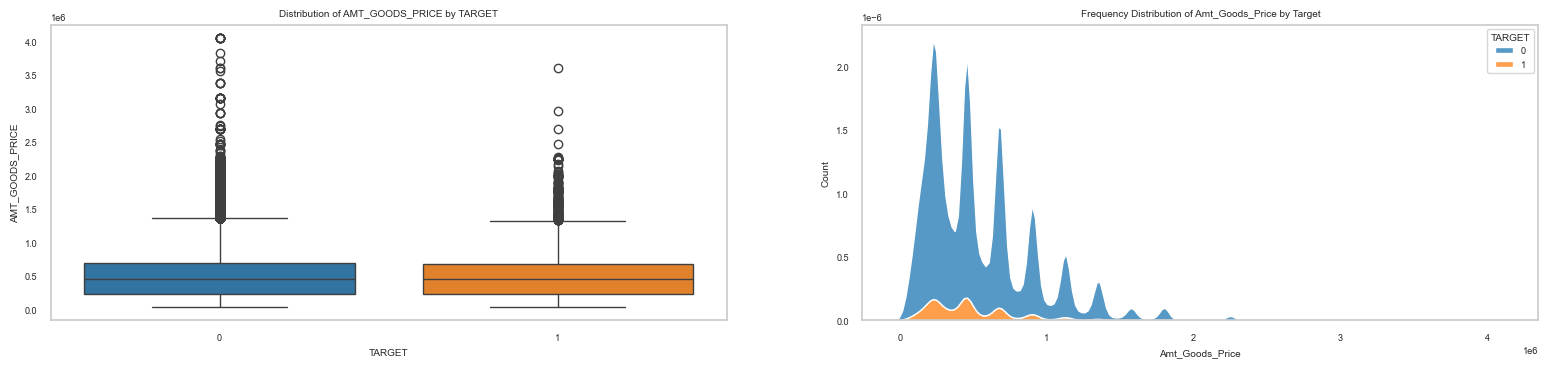

,Column,Test Name,P-value,Test Statistic,Effect Size,Median Group 0,Median Group 1,Significance,Effect Magnitude
0,EXT_SOURCE_2,Mann-Whitney U test,0,4584913929.50,0.31,0.57,0.44,Statistically significant,small
1,EXT_SOURCE_3,Mann-Whitney U test,0,2958253947.50,0.36,0.55,0.38,Statistically significant,small
2,POS_CASH_INSTALLMENT_TREND,Mann-Whitney U test,0,3274216121.50,0.04,-1.50,-2.35,Statistically significant,negligible
3,AVG_PAYMENT_DELAY,Mann-Whitney U test,0,2923604112.50,-0.09,-9.62,-8.63,Statistically significant,negligible
4,DAYS_BIRTH,Mann-Whitney U test,0,2926354691.50,-0.17,-15877,-14282,Statistically significant,negligible
5,DAYS_ID_PUBLISH,Mann-Whitney U test,0,3118165526,-0.11,-3295,-2797,Statistically significant,negligible
6,DAYS_REGISTRATION,Mann-Whitney U test,0,3210111966,-0.09,-4544,-4056,Statistically significant,negligible
7,DAYS_EMPLOYED,Mann-Whitney U test,0,2100007077.50,-0.16,-1691,-1230,Statistically significant,negligible
8,PAYMENT_TO_INCOME,Mann-Whitney U test,0,3371632252.50,-0.04,0.16,0.17,Statistically significant,negligible
9,PREV_LOAN_PERFORMANCE,Mann-Whitney U test,0,2969384094.50,0.20,0.93,0.90,Statistically significant,negligible


In [32]:
df_significance_num = pd.DataFrame()
eda_numerical_columns = df_feature_importances['Feature'].tolist()[:20]

for num_col in eda_numerical_columns:
    result = numerical_predictor_significance_test(df_train, predictor=num_col, target='TARGET',
                                                    test_type='mann_whitney', missing_strategy='drop')
    df_significance_num = interpret_results_numerical(df_significance_num, result, col_name=num_col)
    print(f"Feature: {num_col}. p-value: {result['p_value']:.4f}. Effect size: {result['effect_size']:.4f}")
    draw_predictor_numerical_plots(df_train, predictor=num_col, target='TARGET', hist_type='kde')
    
df_significance_num

<div class="next-steps">
    <h3>Observations</h3>
    <p>Numerical Features - Statistical Significance between groups</p>
    <ol>
        <ul>Most differences between features and label distributions were regarded as statistically significant, yet only three features had a non-negligible effect magnitude</ul>
        <ul><code>EXT_SOURCE_</code> features were the only features that had an effect magnitude (observable difference between groups)</ul>
    </ol>
</div>

## Categorical Predictors
We will explore all categorical features using Chi-Squared significance testing & Cramer V effect magnitude.

Feature: NAME_CONTRACT_TYPE. p-value: 0.0000. Effect size: 0.0309


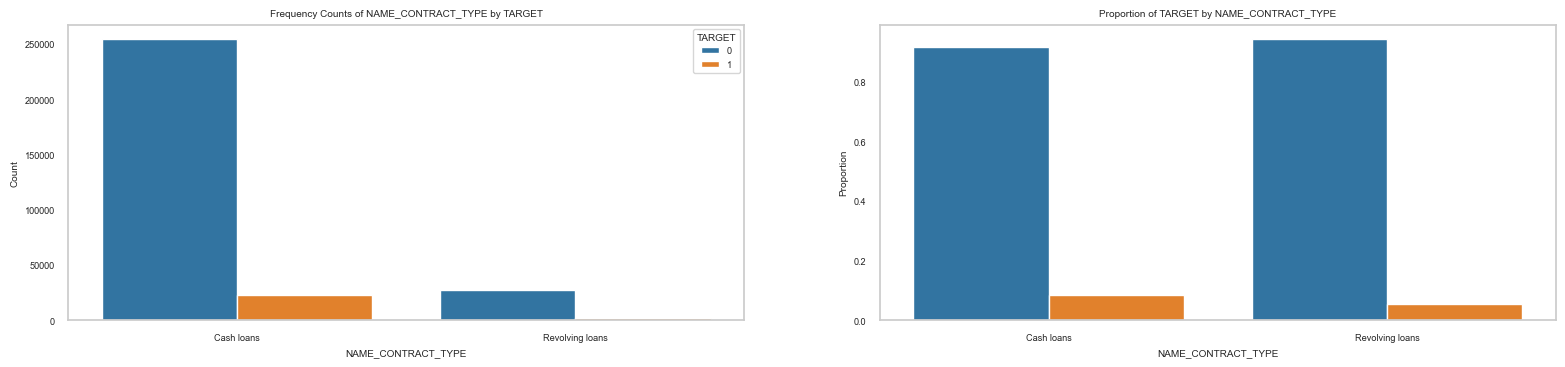

Feature: CODE_GENDER. p-value: 0.0000. Effect size: 0.0547


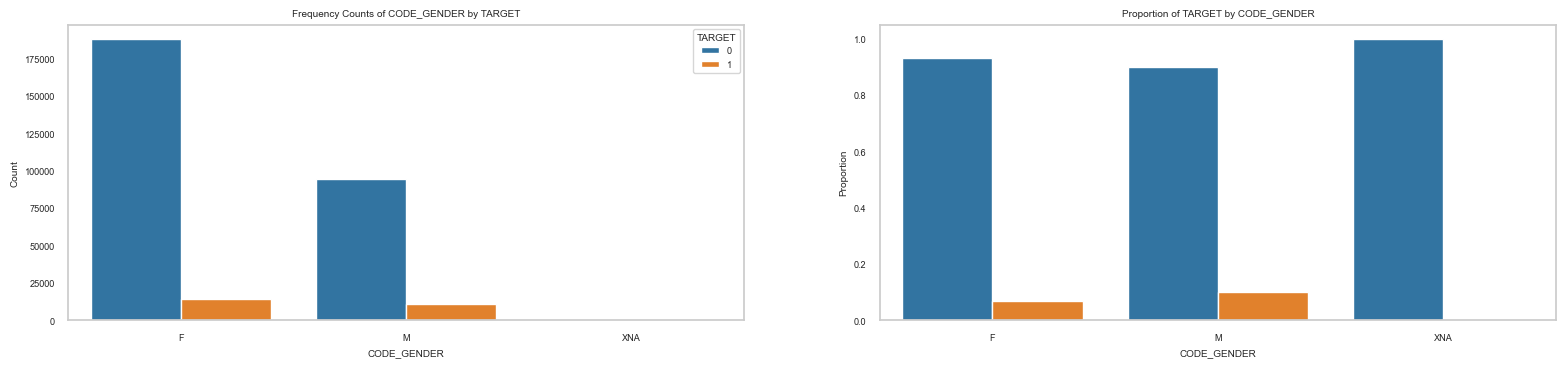

Feature: NAME_TYPE_SUITE. p-value: 0.0000. Effect size: 0.0104


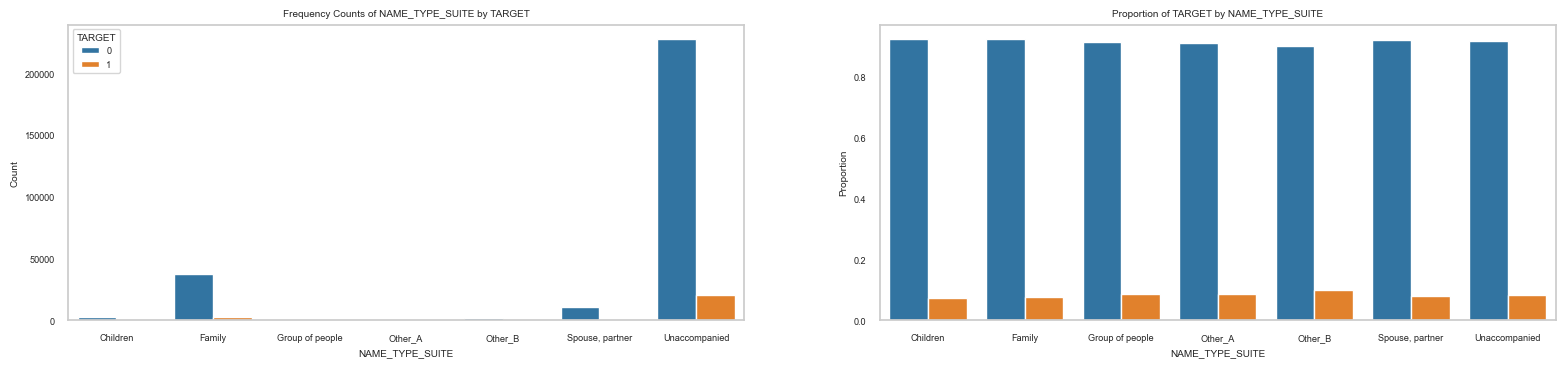

Feature: NAME_INCOME_TYPE. p-value: 0.0000. Effect size: 0.0638


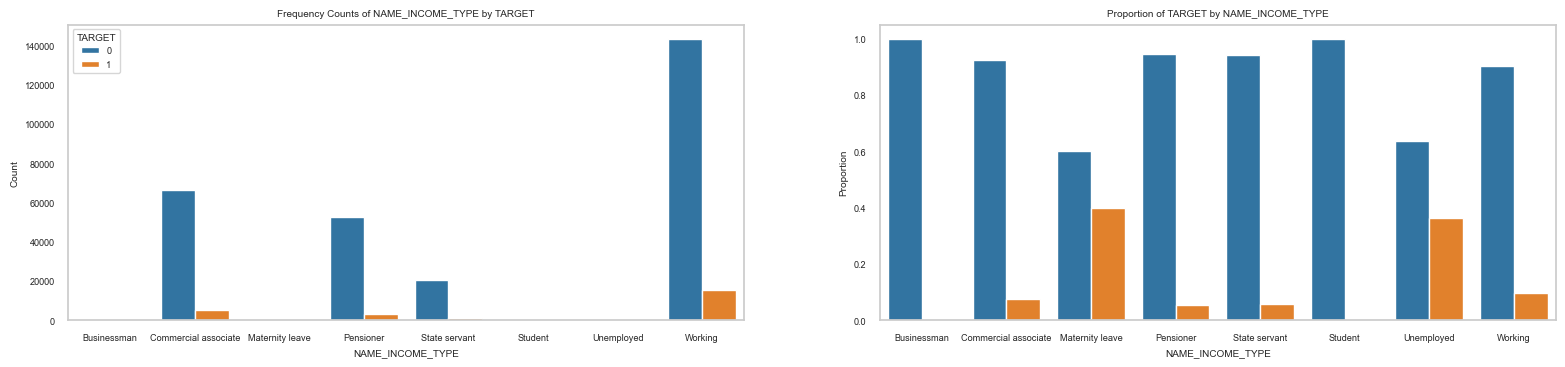

Feature: NAME_EDUCATION_TYPE. p-value: 0.0000. Effect size: 0.0576


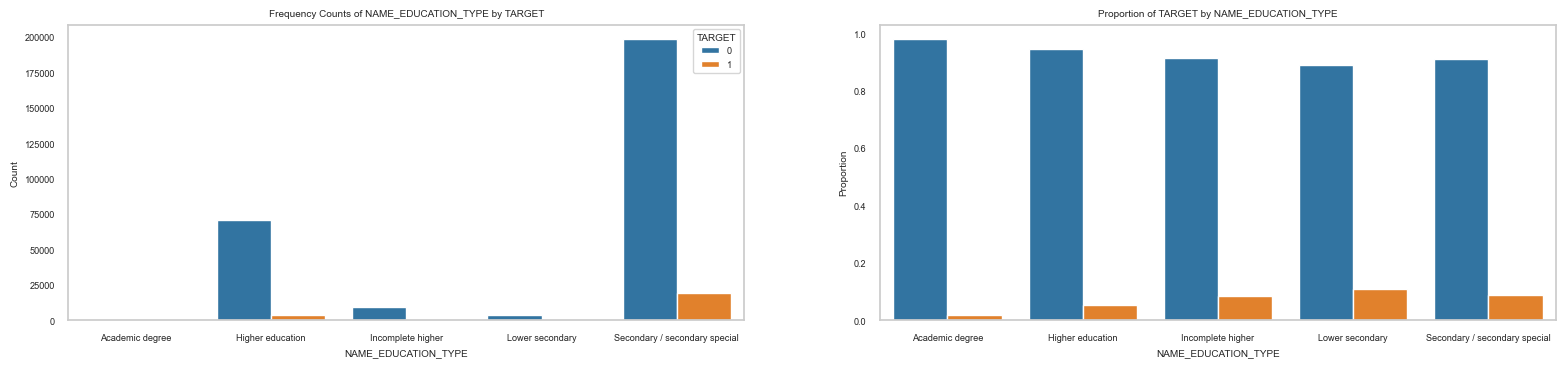

Feature: NAME_FAMILY_STATUS. p-value: 0.0000. Effect size: 0.0405


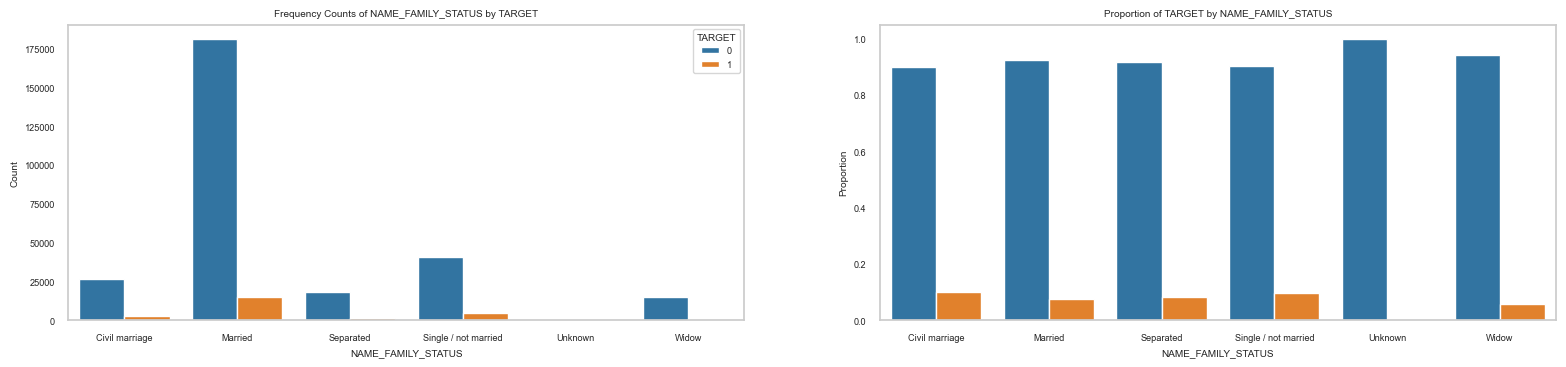

Feature: NAME_HOUSING_TYPE. p-value: 0.0000. Effect size: 0.0370


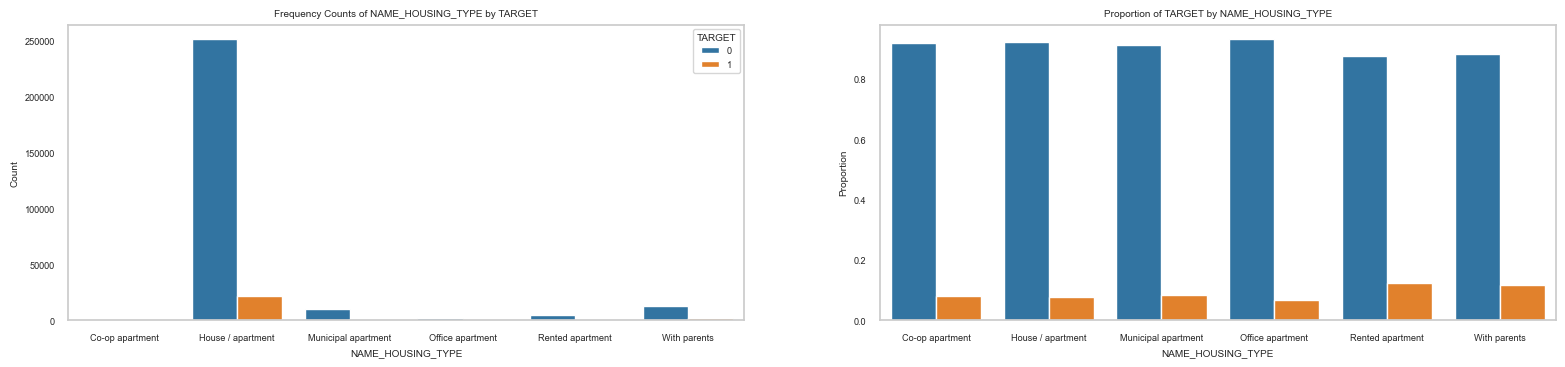

Feature: OCCUPATION_TYPE. p-value: 0.0000. Effect size: 0.0801


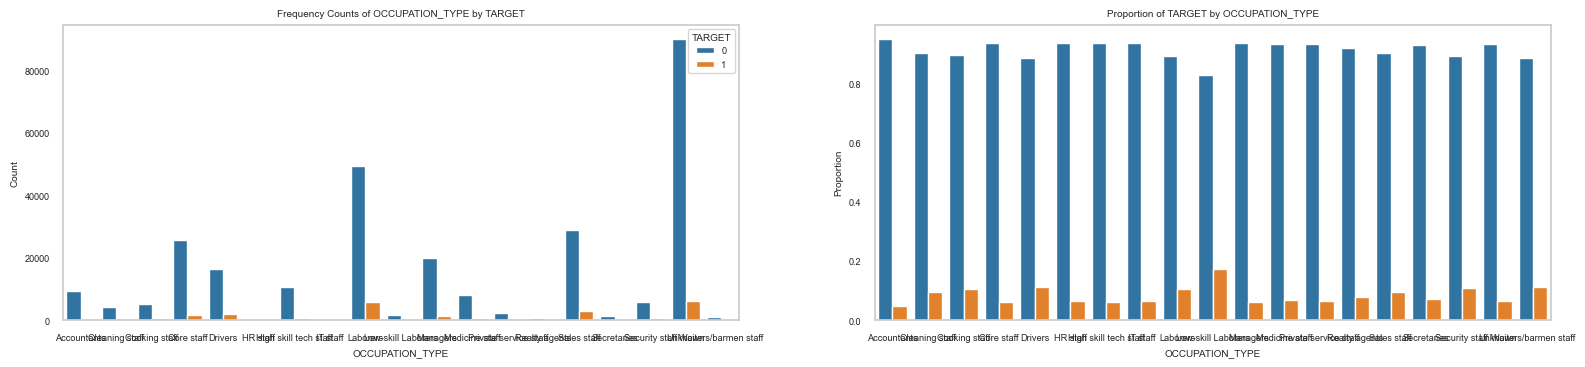

Feature: WEEKDAY_APPR_PROCESS_START. p-value: 0.0174. Effect size: 0.0071


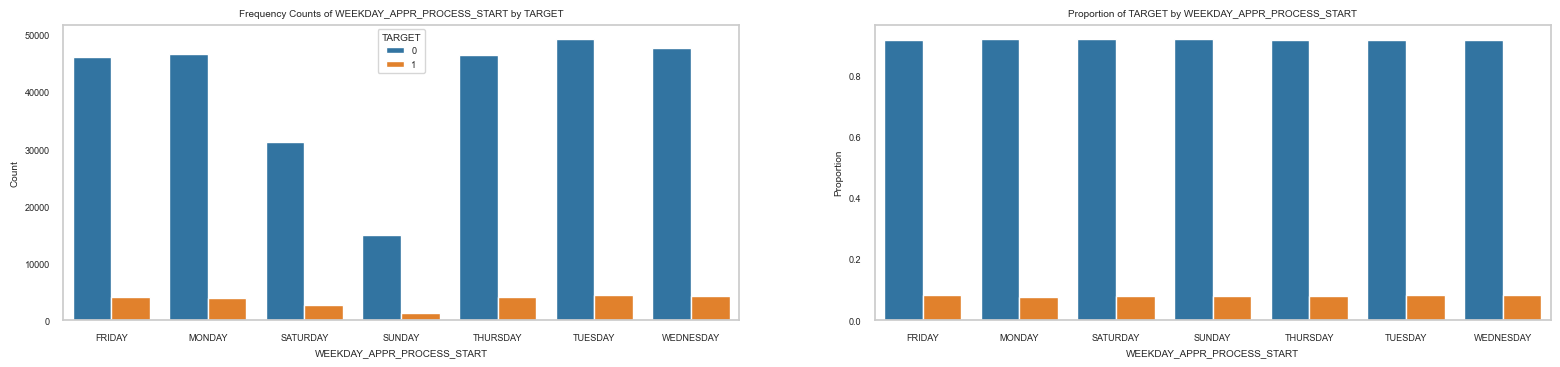

Feature: ORGANIZATION_TYPE. p-value: 0.0000. Effect size: 0.0723


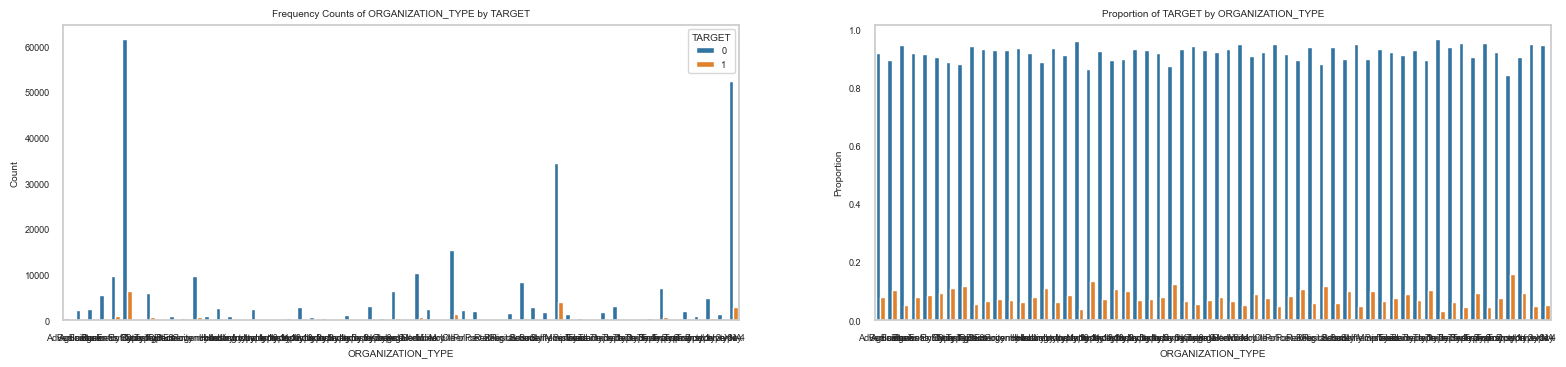

Feature: FONDKAPREMONT_MODE. p-value: 0.0008. Effect size: 0.0131


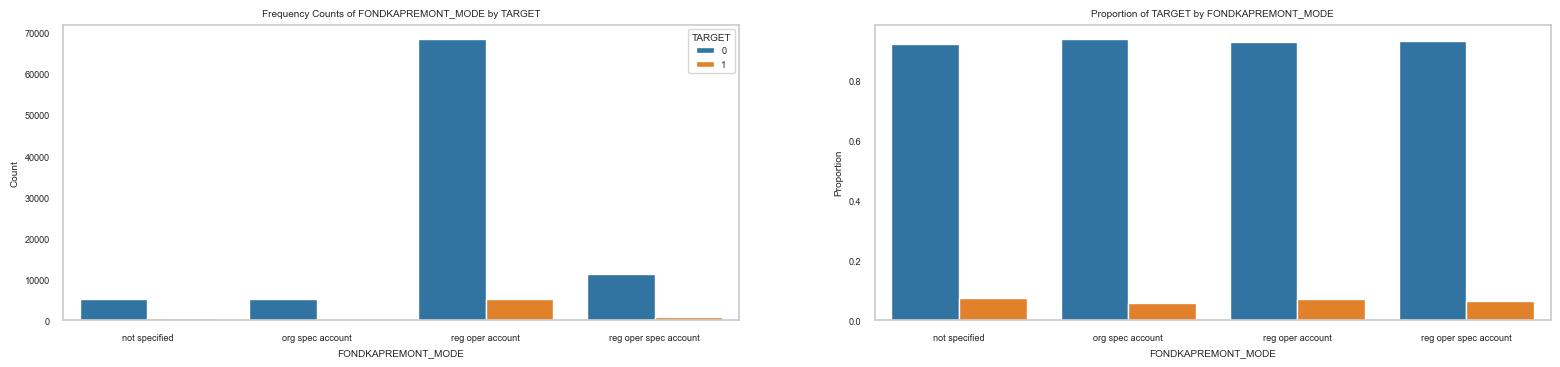

Feature: HOUSETYPE_MODE. p-value: 0.0000. Effect size: 0.0134


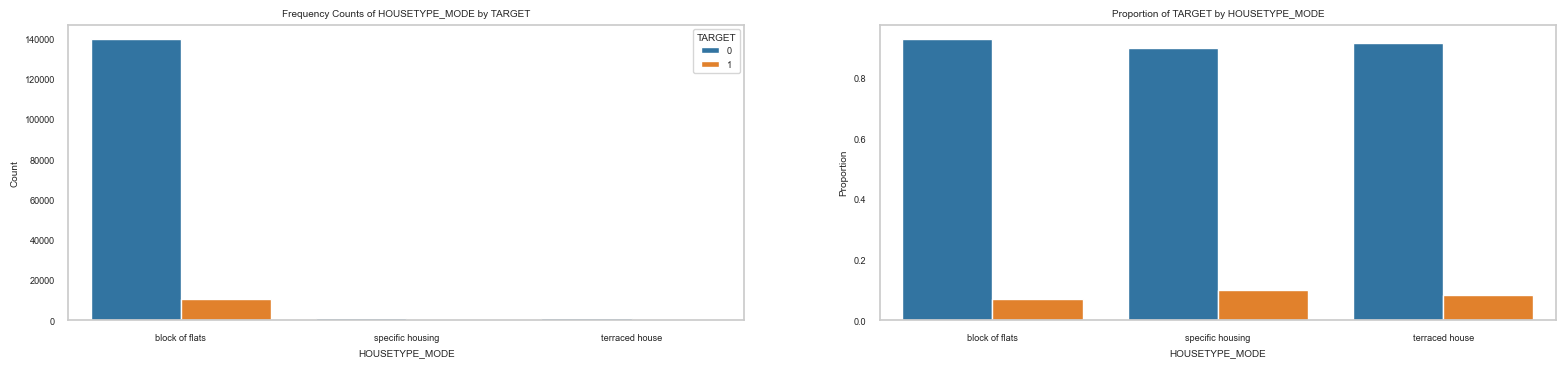

Feature: WALLSMATERIAL_MODE. p-value: 0.0000. Effect size: 0.0303


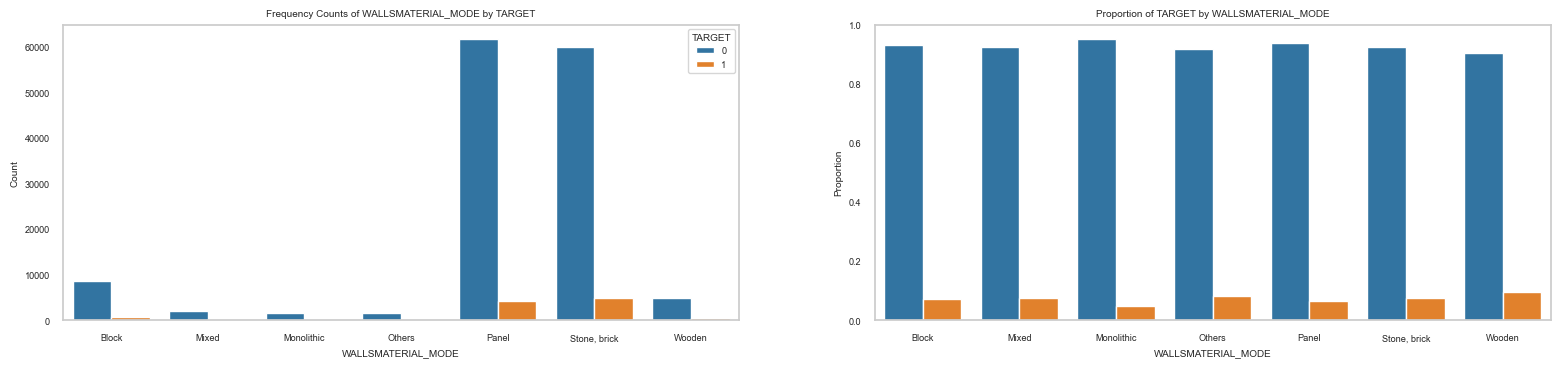

Feature: EMERGENCYSTATE_MODE. p-value: 0.0000. Effect size: 0.0121


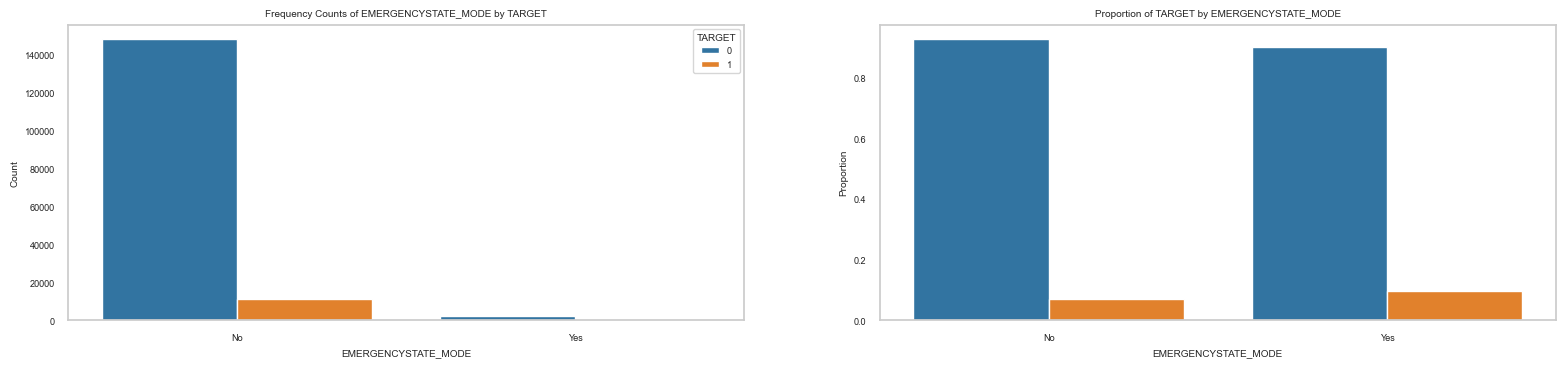

Feature: EMPLOYMENT_STABILITY. p-value: 0.0000. Effect size: 0.0756


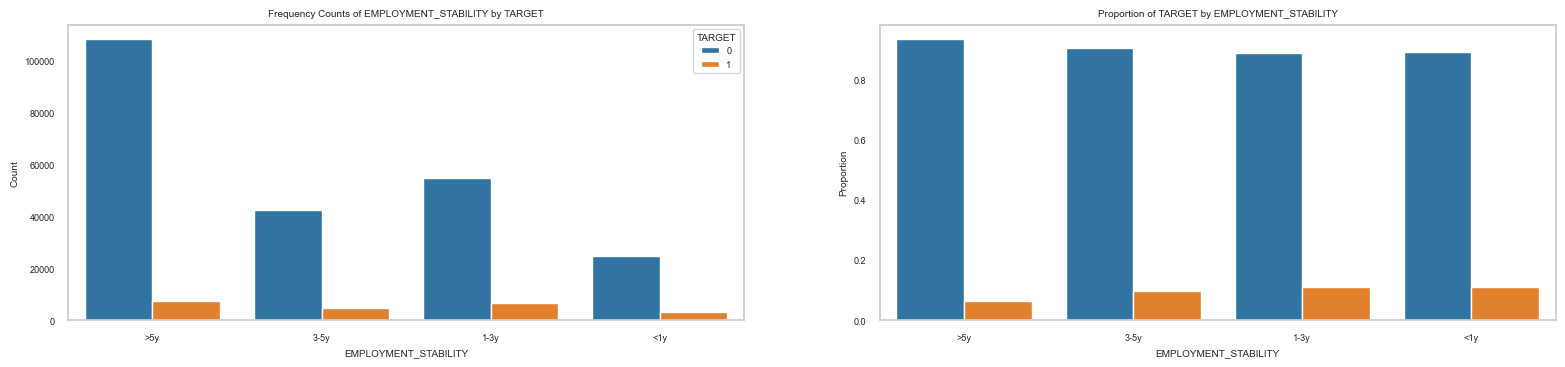

Feature: AGE_GROUP. p-value: 0.0000. Effect size: 0.0769


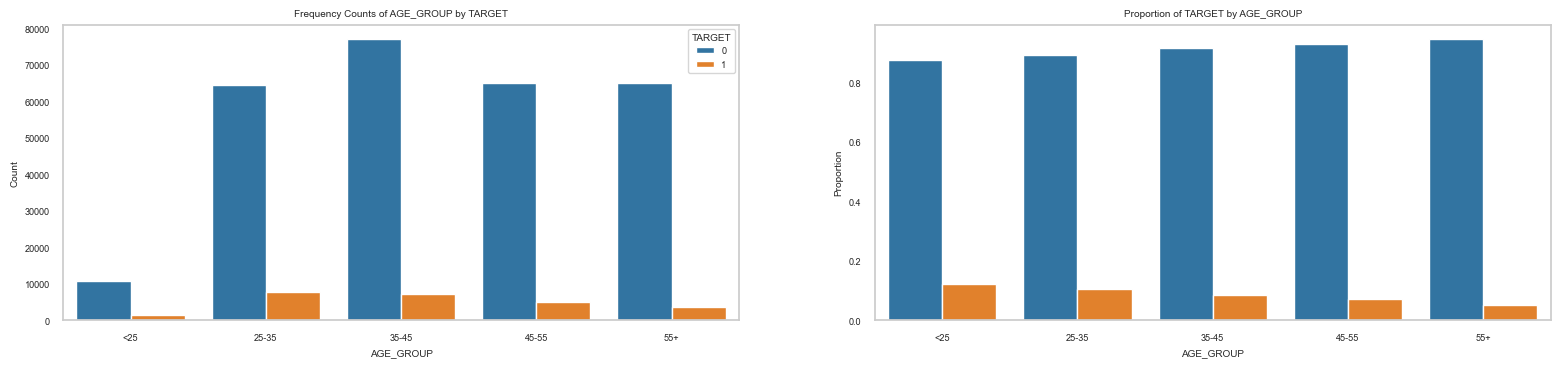

,Column,Test Name,P-value,Chi-squared statistic,Degrees of freedom,Effect size (Cramer's V),Significance,Effect Magnitude
0,NAME_CONTRACT_TYPE,Chi-squared test,0,293.15,1,0.03,Statistically significant,negligible
1,CODE_GENDER,Chi-squared test,0,920.79,2,0.05,Statistically significant,negligible
2,NAME_TYPE_SUITE,Chi-squared test,0.00,32.83,6,0.01,Statistically significant,negligible
3,NAME_INCOME_TYPE,Chi-squared test,0,1253.47,7,0.06,Statistically significant,negligible
4,NAME_EDUCATION_TYPE,Chi-squared test,0,1019.21,4,0.06,Statistically significant,negligible
5,NAME_FAMILY_STATUS,Chi-squared test,0,504.69,5,0.04,Statistically significant,negligible
6,NAME_HOUSING_TYPE,Chi-squared test,0,420.56,5,0.04,Statistically significant,negligible
7,OCCUPATION_TYPE,Chi-squared test,0,1975.08,18,0.08,Statistically significant,negligible
8,WEEKDAY_APPR_PROCESS_START,Chi-squared test,0.02,15.39,6,0.01,Statistically significant,negligible
9,ORGANIZATION_TYPE,Chi-squared test,0,1609.24,57,0.07,Statistically significant,negligible


In [33]:
df_significance_cat = pd.DataFrame()
categorical_columns = df_train.select_dtypes(include=['object', 'category']).columns
for cat_col in exclude_list_value(categorical_columns, 'TARGET'):
    result = categorical_predictor_significance_test(df_train, predictor=cat_col, target='TARGET')
    df_significance_cat = interpret_results_categorical(df_significance_cat, result, col_name=cat_col)
    print(f"Feature: {cat_col}. p-value: {result['p_value']:.4f}. Effect size: {result['effect_size']:.4f}")
    draw_predictor_categorical_plots(df_train, predictor=cat_col, target='TARGET')
    
df_significance_cat

<div class="next-steps">
    <h3>Observations</h3>
    <p></p>
    <ol>
        <ul>All differences between features and label distributions were regarded as statistically significant, but negligible</ul>
        <ul>Out of all the features, <code>OCCUPATION_TYPE</code> had the largest effect size</ul>
    </ol>
</div>

## Feature Correlations
Let's see how the top 20 most important numeric variables and the categorical variables interact between each other and provide meaningful information to the target variable. We will be using **Phik's Coefficient**.

Phik correlation is a statistical measure that can detect both linear and non-linear relationships between variables, making it suitable for both numeric and categorical data. It assumes that the underlying relationship between variables can be approximated by a grid of contingency tables. The Phik correlation coefficient ranges from 0 to 1, where 0 indicates no correlation and 1 indicates perfect correlation, regardless of whether the relationship is linear or non-linear.

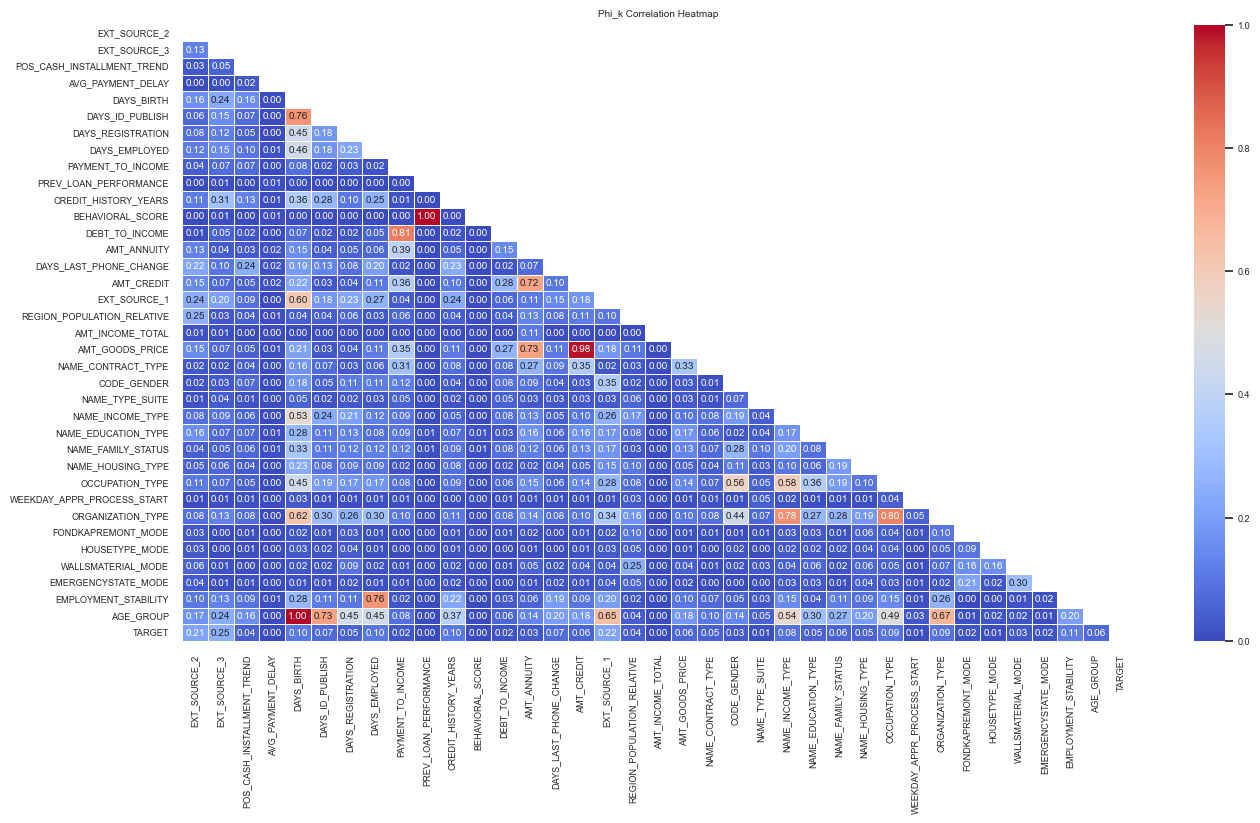

In [34]:
corr_columns = eda_numerical_columns[:20] + categorical_columns.tolist() + ['TARGET']
df_feature_target, df_top_interactions = phik_matrix(df_train[corr_columns], eda_numerical_columns[:20])

In [35]:
print(f"Top 10 feature-target correlations:")
display(df_feature_target)
print(f"Top 10 overall interactions:") 
display(df_top_interactions)

Top 10 feature-target correlations:


,Feature,Phik Coefficient
0,EXT_SOURCE_3,0.25
1,EXT_SOURCE_1,0.22
2,EXT_SOURCE_2,0.21
3,EMPLOYMENT_STABILITY,0.11
4,DAYS_EMPLOYED,0.10
5,DAYS_BIRTH,0.10
6,CREDIT_HISTORY_YEARS,0.10
7,OCCUPATION_TYPE,0.09
8,ORGANIZATION_TYPE,0.09
9,NAME_INCOME_TYPE,0.08


Top 10 overall interactions:


,Feature1,Feature2,Phik Coefficient
416,BEHAVIORAL_SCORE,PREV_LOAN_PERFORMANCE,1
1299,AGE_GROUP,DAYS_BIRTH,1.00
574,AMT_CREDIT,AMT_GOODS_PRICE,0.98
452,DEBT_TO_INCOME,PAYMENT_TO_INCOME,0.81
1028,OCCUPATION_TYPE,ORGANIZATION_TYPE,0.80
880,NAME_INCOME_TYPE,ORGANIZATION_TYPE,0.78
153,DAYS_BIRTH,DAYS_ID_PUBLISH,0.76
293,DAYS_EMPLOYED,EMPLOYMENT_STABILITY,0.76
500,AMT_ANNUITY,AMT_GOODS_PRICE,0.73
1300,AGE_GROUP,DAYS_ID_PUBLISH,0.73


<div class="results">
    <h3>EDA Results</h3>
    <p>Key predictors</p>
    <ol>
        <ul><code>EXT_SOURCE_</code> features are top predictors in determining whether a client is risky or not</ul>
        <ul>Employment length, age and occupation have slight correlations with the target variable</ul>
        <ul>For feature-feature interactions, the credit amount is mostly perfectly correlated to goods price</ul>
        <ul>Additionally, some newly created features are correlated with their component features. Since they represent different expressions of data (numerical vs categorical), we will leave them</ul>
    </ol>
</div>

# Statistical Modeling
* Data Split: **Train-test** with `RepeatedStratifiedKFold`
* Performance Metric: **Area under the ROC curve**
* Baseline Model: **XGBoost with original features** 
* Operational Models:
  * XGBoost
  * LightGBM
  * CatBoostClassifier
  * BalancedRandomForestClassifier

All the listed models support datasets with missing features, and some models have built-in class imbalance handling.

After we tune the models, we will test ensemble methods to see if we get a better result from a meta-model.

In [45]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

X_train = df_train.drop(columns=['TARGET'], axis=1)
X_test = df_test.copy()
y_train = df_train['TARGET']

if y_train.dtype.name == 'category':
    y_train = y_train.cat.codes  
else:
    y_train = y_train.astype(float)

xgb = XGBClassifier(random_state=RANDOM_STATE, scale_pos_weight=weight_ratio)
lgbm = LGBMClassifier(random_state=RANDOM_STATE, verbose=-1, class_weight=class_weights)
catboost = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False, class_weights=weights_array)
rf = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
baseline = XGBClassifier(random_state=RANDOM_STATE, scale_pos_weight=weight_ratio)

models = {
    'XGBoost': xgb,
    'LightGBM': lgbm,
    'CatBoost': catboost,
    'RandomForest': rf,
}

df_performance = pd.DataFrame(columns=['Model'])
df_performance['Model'] = models.keys()

## Model Baseline
Let's train the baseline model and submit the results to the Kaggle competition.

The baseline will use `df_train_raw` - the initial training dataset with all original features. Additionally, we will perform these steps:
* Dropping client identification `SK_CURR_ID`
* Encoding the categorical columns using standard One-hot Encoding

In [46]:
df_train_raw = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'))
df_test_raw = pd.read_csv(os.path.join(DATA_PATH, 'application_test.csv'))

id_column = 'SK_ID_CURR'
X_raw = df_train_raw.drop(columns=[id_column, 'TARGET'], axis=1)
X_raw_test = df_test_raw.drop(columns=[id_column], axis=1)
y_raw = df_train_raw['TARGET']
test_id = df_test_raw['SK_ID_CURR']

numerical_columns = X_raw.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X_raw.select_dtypes(exclude=['float64', 'int64']).columns
encoded = pd.get_dummies(X_raw[categorical_columns], drop_first=True)
X_raw = X_raw[numerical_columns]
X_raw = X_raw.join(encoded)
X_raw_test = X_raw_test[numerical_columns]
X_raw_test = X_raw_test.join(encoded)


Model: XGBClassifier
Overall ROC AUC: 0.7536
Mean Fold ROC AUC: 0.7438 (+/- 0.0026)
95% Confidence Interval: (0.7424, 0.7453)
Coefficient of Variation: 0.0034
Model performance is very stable across folds.


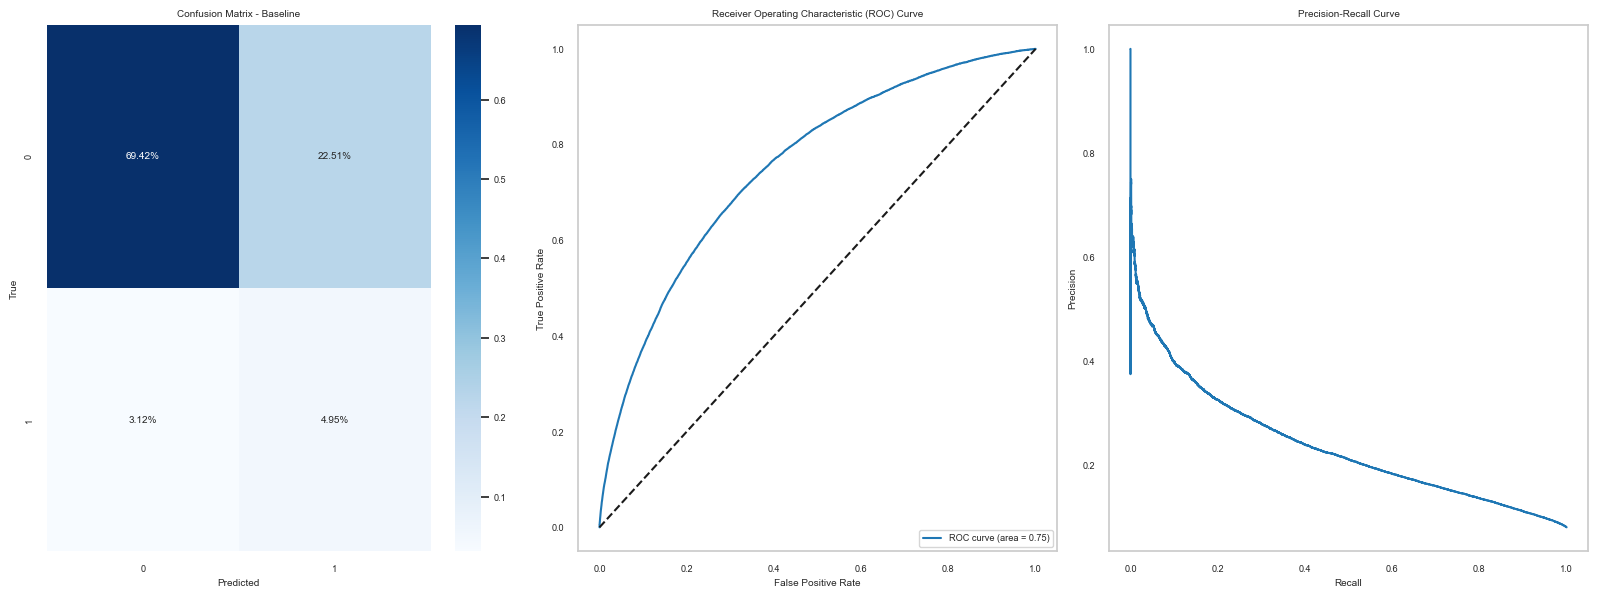

In [47]:
roc_auc, y_pred, y_pred_proba = calculate_roc_auc_score(baseline, X_raw, y_raw, rskf)
export_predictions(baseline, X_raw_test, test_id, 'baseline')

visualize_performance(y=y_raw, y_pred=y_pred, y_pred_proba=y_pred_proba, model_name='Baseline')

del X_raw, y_raw, df_train_raw, df_test_raw

The score using training data is **0.7536**. Let's submit the predictions to Kaggle and see operational performance.

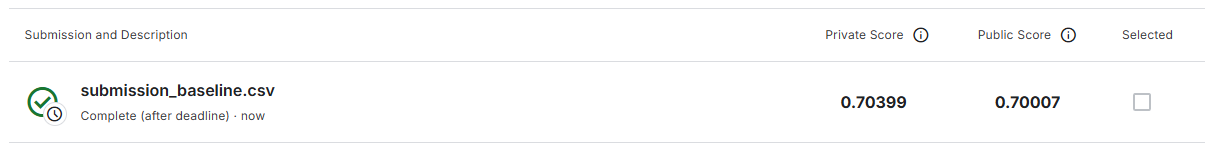

In [48]:
Image('media/baseline_score.png')

<div class="next-steps">
    <h3>Observations</h3>
    <p>Baseline Model</p>
    <ol>
        <ul>The operational performance is <b>0.70</b>, worse than the training score. This will be the baseline</ul>
        <ul>Much worse operational performance might indicate overfitting</ul>
        <ul>The baseline model has a significant false positive rate</ul>
    </ol>
</div>

## Dataset Improvements
Before we perform hyperparameter tuning for each model, let's optimize the dataset.
* Include the newly created domain knowledge features (already included in `X_train`)
* Mean encoding for high cardinality features (>10 features), One-Hot Encoding for others
* Keep 95% of features through an ensemble of feature selection using `XGBoost` and `LightGBM` feature importances functionality
* Log-transform highly skewed features with `Box Cox`
* Scale all features with `RobustScaler`

In [49]:
# Encoding
X_train, X_test, y_train = encoding_step(X_train, X_test, y_train, cardinality_threshold=10)
print(f"Training dataset shape (post-encoding): {X_train.shape}")
print(f"Test dataset shape: (post-encoding) {X_test.shape}")

# Alignment
X_train, X_test = X_train.align(X_test, join='inner', axis=1)
print(f"\nTraining dataset shape (post-alignment): {X_train.shape}")
print(f"Test dataset shape: (post-alignment) {X_test.shape}")

# Feature selection
feature_importances = ensemble_feature_importance(X_train, y_train, n_iterations=10)
feature_importances = feature_importances.sort_values(ascending=False)
features_keep = feature_importances[:int(len(feature_importances) * 0.90)]
X_train = X_train[features_keep.index]
X_test = X_test[features_keep.index]
print(f"\nTraining dataset shape (post-feature selection): {X_train.shape}")
print(f"Test dataset shape: (post-feature selection) {X_test.shape}")

# Box-Cox transform and scaling
X_train, X_test, y_train = transform_and_scaling_step(X_train, X_test, y_train, skew_threshold=0.5, lmbda=0.15)

print(f"\nTraining dataset shape: {X_train.shape}")
print(f"Test dataset shape: {X_test.shape}")

Training dataset shape (post-encoding): (307511, 166)
Test dataset shape: (post-encoding) (48744, 167)

Training dataset shape (post-alignment): (307511, 166)
Test dataset shape: (post-alignment) (48744, 166)

Training dataset shape (post-feature selection): (307511, 149)
Test dataset shape: (post-feature selection) (48744, 149)

Training dataset shape: (307511, 148)
Test dataset shape: (48744, 148)


<div class="next-steps">
    <h3>Observations</h3>
    <p>Dataset Feature Engineering</p>
    <ol>
        <ul>The Feature Engineered dataset has 148 features</ul>
        <ul>Data missingness was retained as the models support missing data</ul>
    </ol>
</div>

With the dataset fully prepared, let's train the models and submit the predictions to the competition.


Model: XGBClassifier
Overall ROC AUC: 0.7652
Mean Fold ROC AUC: 0.7535 (+/- 0.0027)
95% Confidence Interval: (0.7519, 0.7551)
Coefficient of Variation: 0.0036
Model performance is very stable across folds.


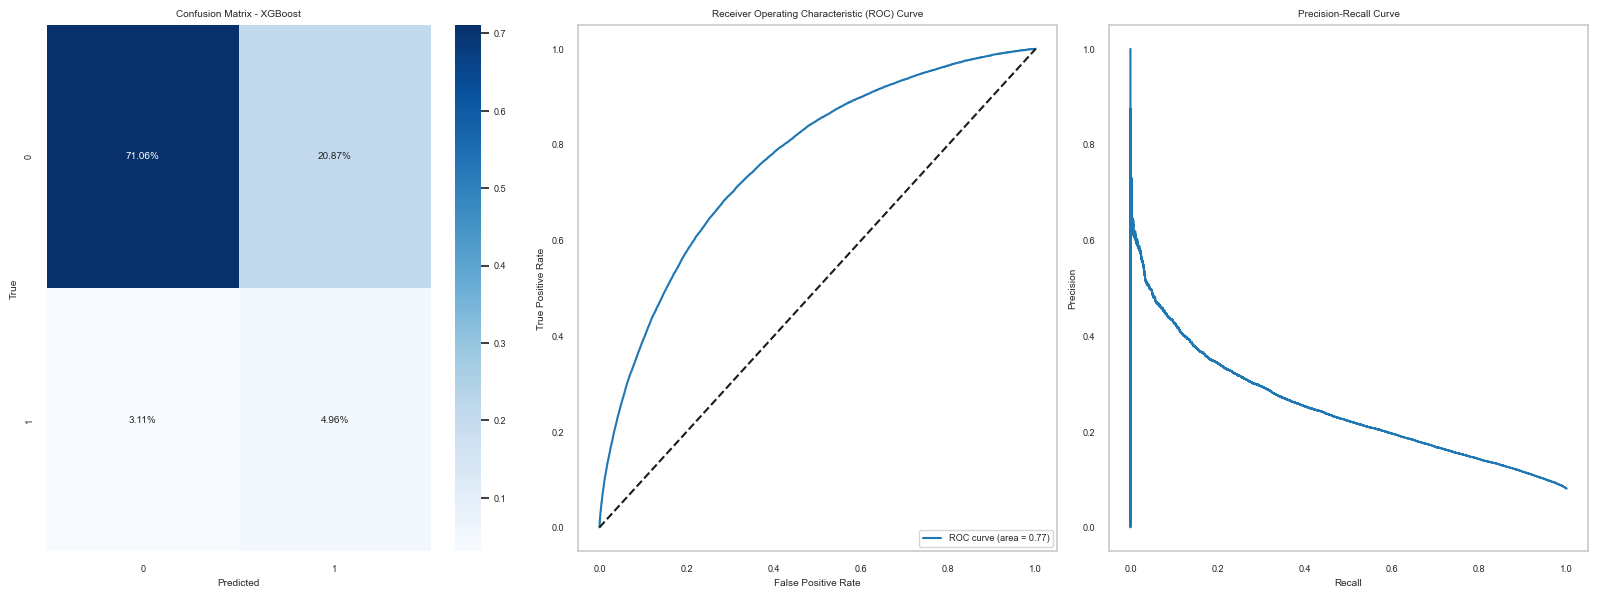

Training time: 46.12 seconds

Model: LGBMClassifier
Overall ROC AUC: 0.7706
Mean Fold ROC AUC: 0.7685 (+/- 0.0027)
95% Confidence Interval: (0.7669, 0.7700)
Coefficient of Variation: 0.0035
Model performance is very stable across folds.


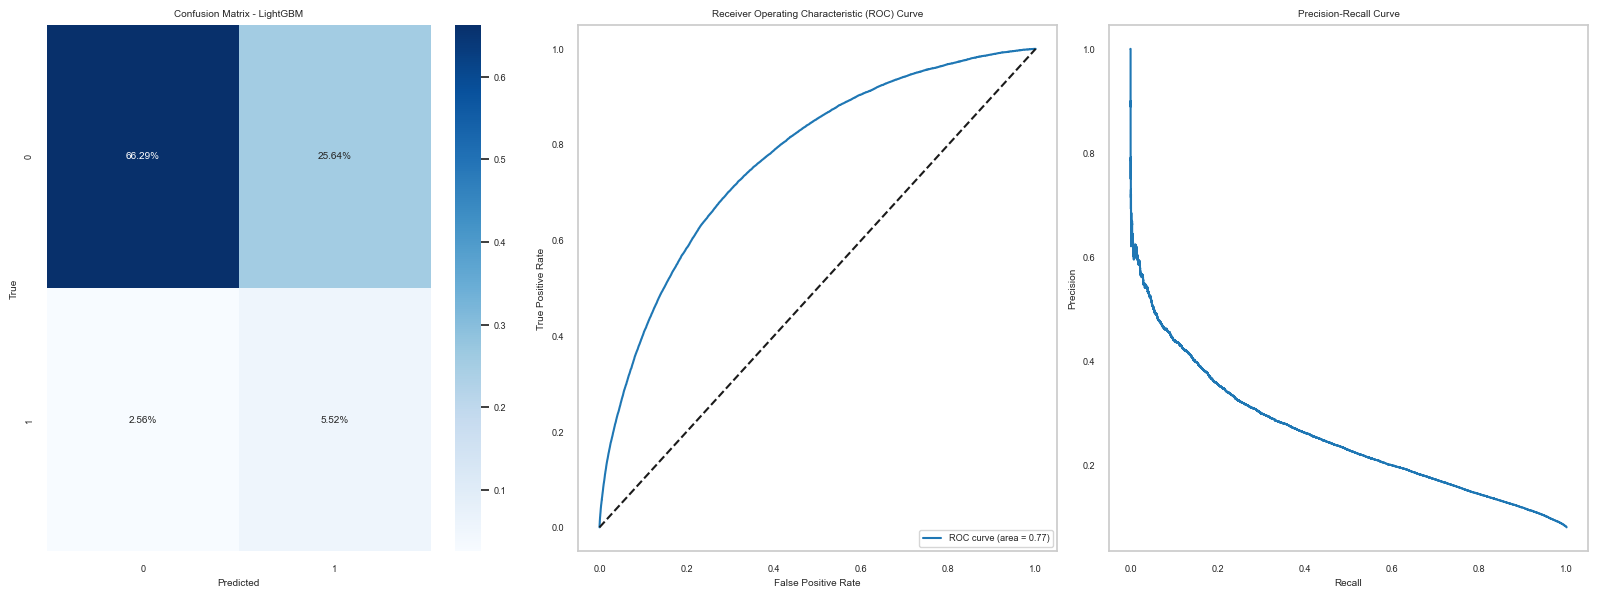

Training time: 35.87 seconds

Model: CatBoostClassifier
Overall ROC AUC: 0.7690
Mean Fold ROC AUC: 0.7631 (+/- 0.0026)
95% Confidence Interval: (0.7616, 0.7646)
Coefficient of Variation: 0.0034
Model performance is very stable across folds.


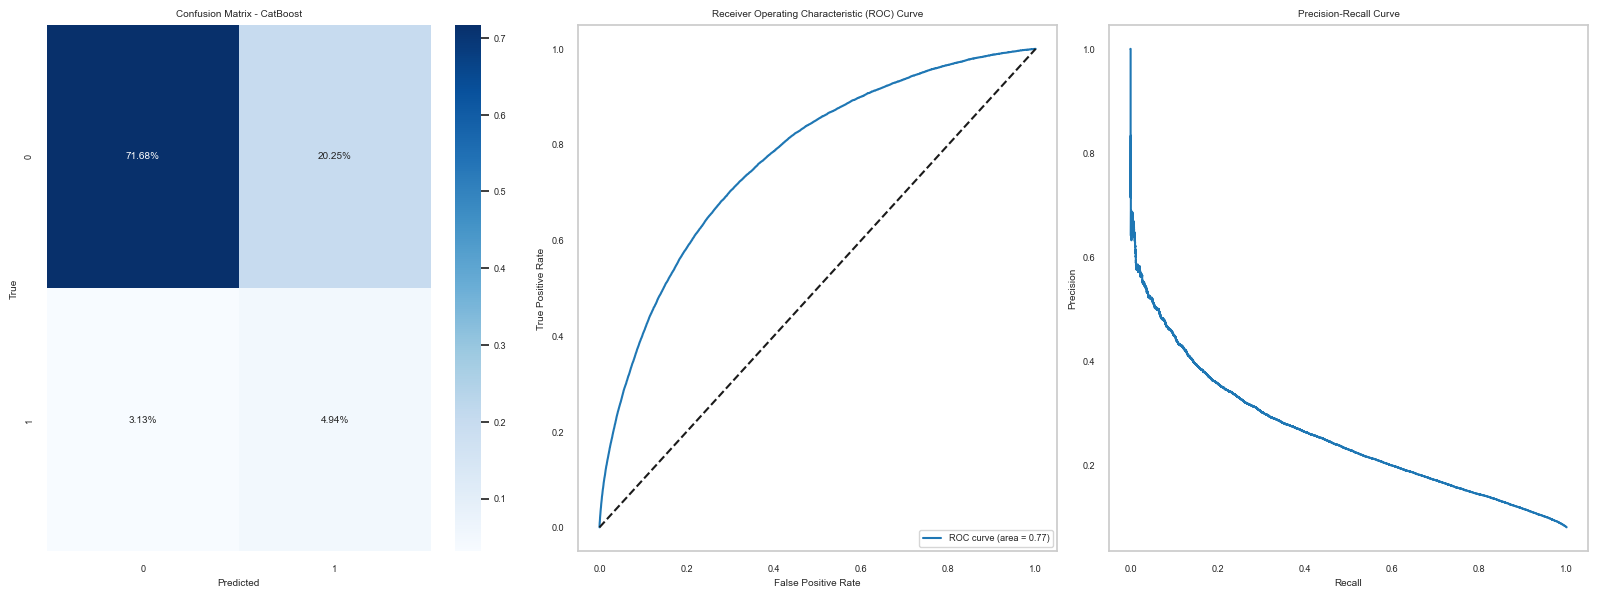

Training time: 635.39 seconds

Model: RandomForestClassifier
Overall ROC AUC: 0.7504
Mean Fold ROC AUC: 0.7333 (+/- 0.0031)
95% Confidence Interval: (0.7315, 0.7351)
Coefficient of Variation: 0.0042
Model performance is very stable across folds.


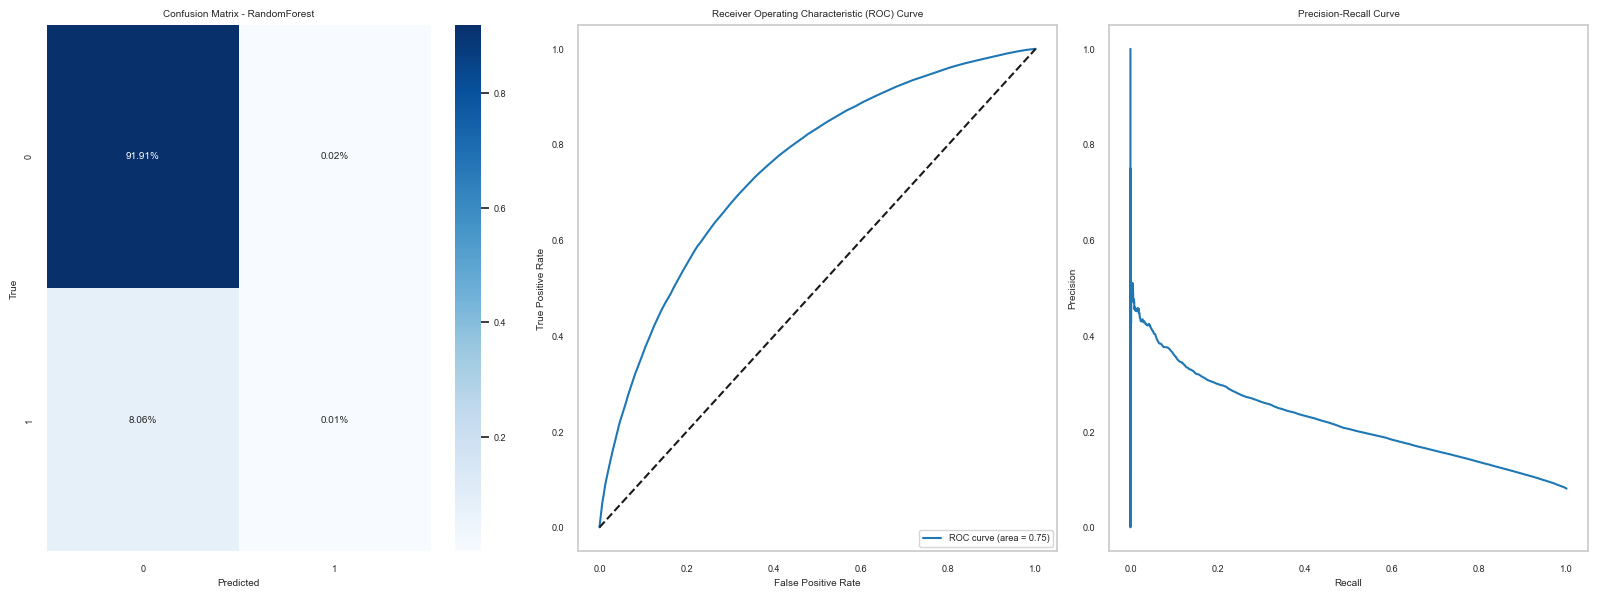

Training time: 1286.28 seconds


,Model,Score (post-FE)
0,XGBoost,0.765
1,LightGBM,0.771
2,CatBoost,0.769
3,RandomForest,0.750


In [50]:
for model_name, model in models.items():
    start_time = time.time()
    roc_auc, y_pred, y_pred_proba = calculate_roc_auc_score(model, X_train, y_train, rskf)
    end_time = time.time()
    training_time = end_time - start_time
    export_predictions(model, X_test, test_id, f'{model_name}_post_FE')
    df_performance.loc[df_performance['Model'] == model_name, 'Score (post-FE)'] = roc_auc
    visualize_performance(y=y_train, y_pred=y_pred, y_pred_proba=y_pred_proba, model_name=model_name)
    print(f"Training time: {training_time:.2f} seconds")

pd.set_option('display.float_format', '{:.3f}'.format)
df_performance

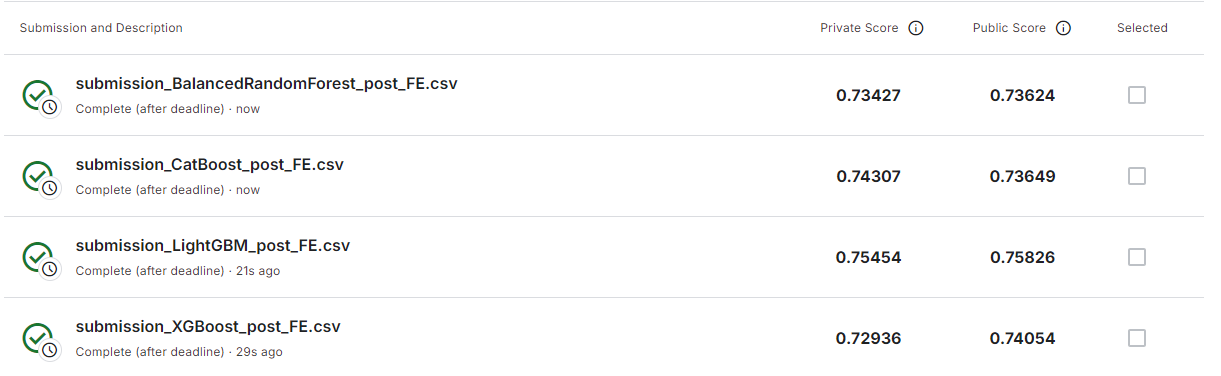

In [51]:
Image('media/post_FE_score.png')

<div class="next-steps">
    <h3>Observations</h3>
    <p>Model Performance - Feature Engineered Dataset</p>
    <ol>
        <ul>All models have a slightly lower AOC score on the test dataset, suggesting slight overfitting</ul>
        <ul>All models have a fairly high false positive rate; XGBoost and CatBoost keep it around 20%</ul>
        <ul>LightGBM is strongly in the lead</ul>
    </ol>
</div>

## Models' Tuning
The next step is to select the best parameters for each model. We will use **Optuna** with 10 trials. Each trial will use the train dataset with a `StratifiedKFold` with 3 splits.

In [52]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def objective(trial):
    # XGBoost
    xgb_params = {
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 8),
        'learning_rate': trial.suggest_loguniform('xgb_learning_rate', 1e-3, 0.1),
        'n_estimators': trial.suggest_int('xgb_n_estimators', 100, 2000),
        'min_child_weight': trial.suggest_int('xgb_min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('xgb_subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('xgb_colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_loguniform('xgb_gamma', 1e-8, 1.0),
        'reg_alpha': trial.suggest_loguniform('xgb_reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('xgb_reg_lambda', 1e-8, 1.0),
        'scale_pos_weight': trial.suggest_uniform('xgb_scale_pos_weight', 10, 12),
    }

    # LightGBM
    lgb_params = {
        'num_leaves': trial.suggest_int('lgb_num_leaves', 20, 500),
        'learning_rate': trial.suggest_loguniform('lgb_learning_rate', 1e-3, 0.1),
        'n_estimators': trial.suggest_int('lgb_n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('lgb_min_child_samples', 5, 100),
        'subsample': trial.suggest_uniform('lgb_subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_uniform('lgb_colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_loguniform('lgb_reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('lgb_reg_lambda', 1e-8, 1.0),
        'min_split_gain': trial.suggest_loguniform('lgb_min_split_gain', 1e-8, 1.0),
        'bagging_fraction': trial.suggest_uniform('lgb_bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('lgb_bagging_freq', 1, 7),
        'scale_pos_weight': trial.suggest_uniform('lgb_scale_pos_weight', 10, 12),
    }

    # CatBoost
    cat_params = {
        'depth': trial.suggest_int('cat_depth', 4, 8),
        'learning_rate': trial.suggest_loguniform('cat_learning_rate', 1e-3, 0.1),
        'iterations': trial.suggest_int('cat_iterations', 100, 2000),
        'l2_leaf_reg': trial.suggest_loguniform('cat_l2_leaf_reg', 1, 10),
        'border_count': trial.suggest_int('cat_border_count', 32, 255),
        'subsample': trial.suggest_uniform('cat_subsample', 0.7, 1.0),
        'rsm': trial.suggest_uniform('cat_rsm', 0.7, 1.0),
        'eval_metric': 'AUC',
        'auto_class_weights': trial.suggest_categorical('cat_auto_class_weights', ['Balanced', 'SqrtBalanced']),
    }

    # Random Forest
    rf_params = {
        'n_estimators': trial.suggest_int('rf_n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('rf_max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('rf_min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('rf_max_features', ['sqrt', 'log2', None]),
        'bootstrap': trial.suggest_categorical('rf_bootstrap', [True, False]),
        'class_weight': 'balanced'
    }

    models = {
        'XGBoost': XGBClassifier(**xgb_params, random_state=RANDOM_STATE),
        'LightGBM': LGBMClassifier(**lgb_params, random_state=RANDOM_STATE),
        'CatBoost': CatBoostClassifier(**cat_params, random_state=RANDOM_STATE, verbose=False),
        'RandomForest': RandomForestClassifier(**rf_params, random_state=RANDOM_STATE)
    }

    cv_scores = []

    for _, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')
        cv_scores.append(np.mean(scores))

    return np.mean(cv_scores)

In [53]:
optuna_logger = logging.getLogger("optuna")
optuna_logger.setLevel(logging.WARNING)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=-1, show_progress_bar=True)
best_params = study.best_params
def extract_params(prefix, params):
    return {k[len(prefix)+1:]: v for k, v in params.items() if k.startswith(prefix)}

final_models = {
    'XGBoost': XGBClassifier(**extract_params('xgb', best_params), random_state=RANDOM_STATE),
    'LightGBM': LGBMClassifier(**extract_params('lgb', best_params), random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(**extract_params('cat', best_params), random_state=RANDOM_STATE,
                                    verbose=False),
    'RandomForest': RandomForestClassifier(**extract_params('rf', best_params),
                                            random_state=RANDOM_STATE)
}

  0%|          | 0/20 [00:00<?, ?it/s]


Model: XGBClassifier
Overall ROC AUC: 0.7703
Mean Fold ROC AUC: 0.7664 (+/- 0.0020)
95% Confidence Interval: (0.7653, 0.7676)
Coefficient of Variation: 0.0026
Model performance is very stable across folds.


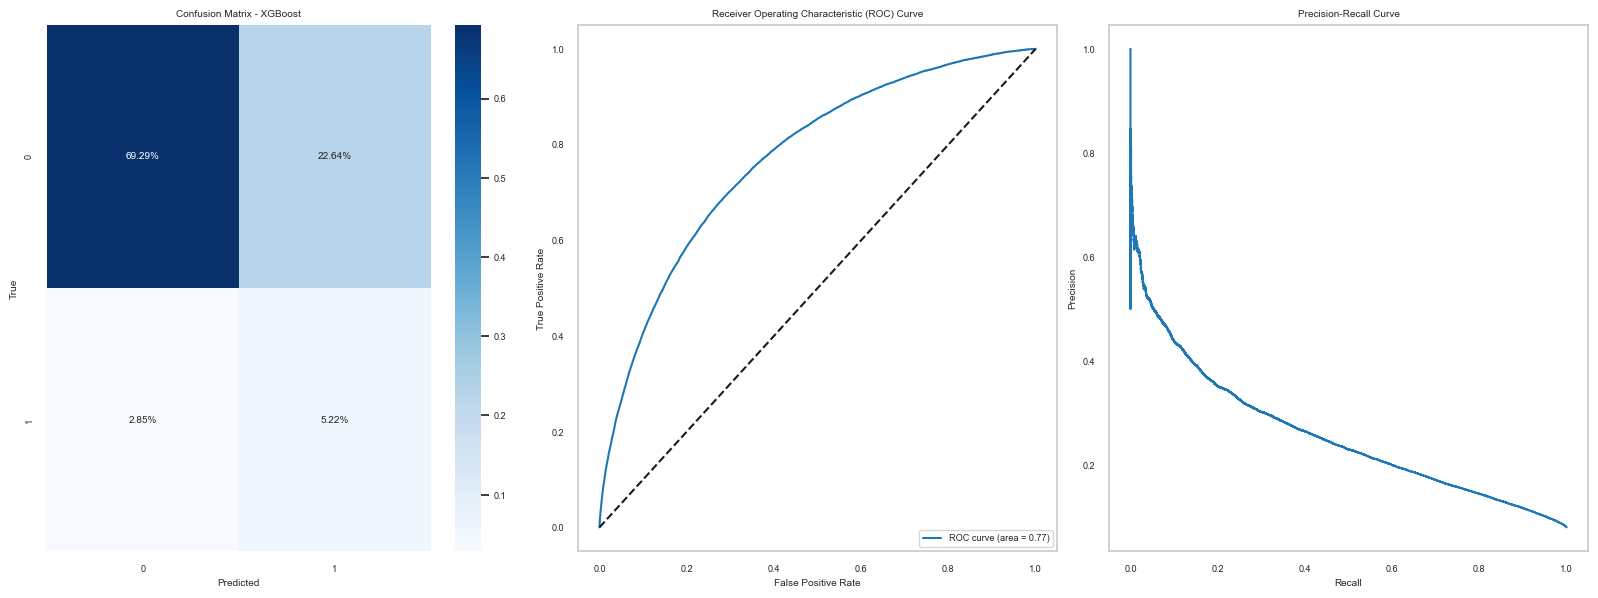


Model: LGBMClassifier
Overall ROC AUC: 0.7731
Mean Fold ROC AUC: 0.7719 (+/- 0.0025)
95% Confidence Interval: (0.7705, 0.7734)
Coefficient of Variation: 0.0033
Model performance is very stable across folds.


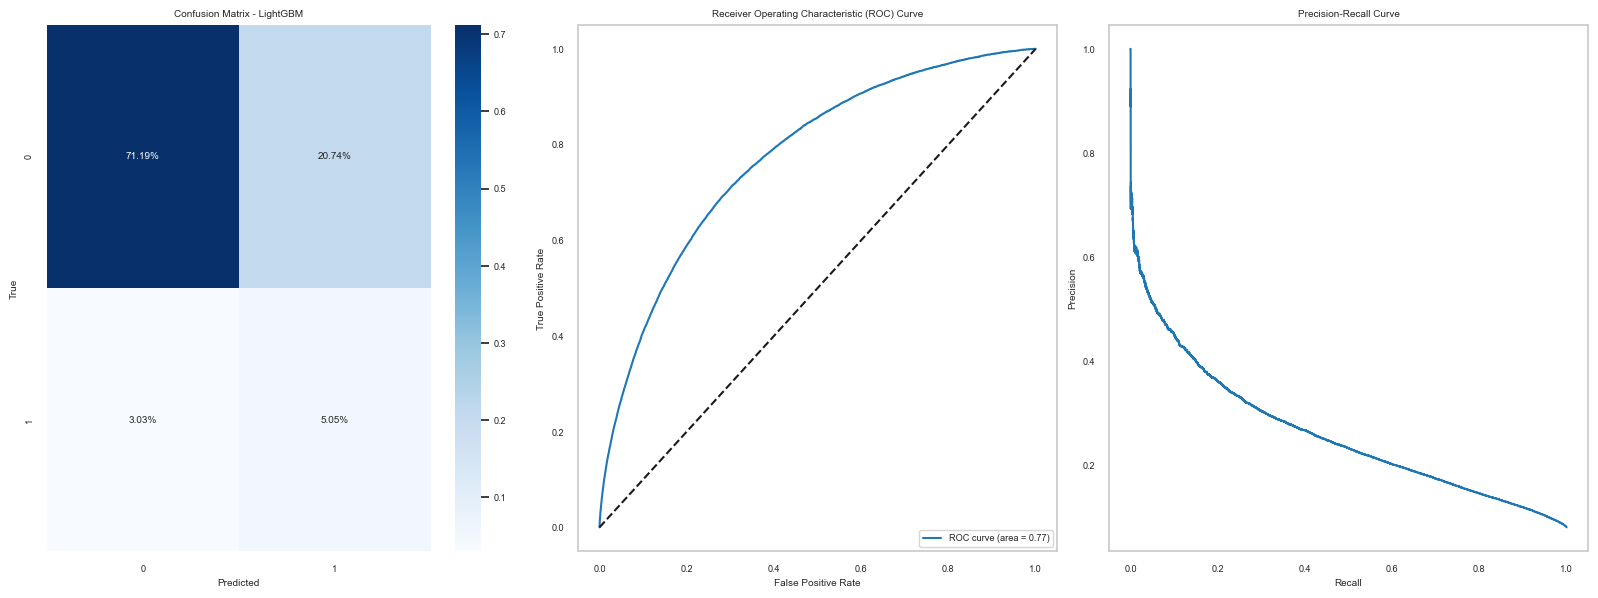


Model: CatBoostClassifier
Overall ROC AUC: 0.7708
Mean Fold ROC AUC: 0.7694 (+/- 0.0024)
95% Confidence Interval: (0.7681, 0.7708)
Coefficient of Variation: 0.0031
Model performance is very stable across folds.


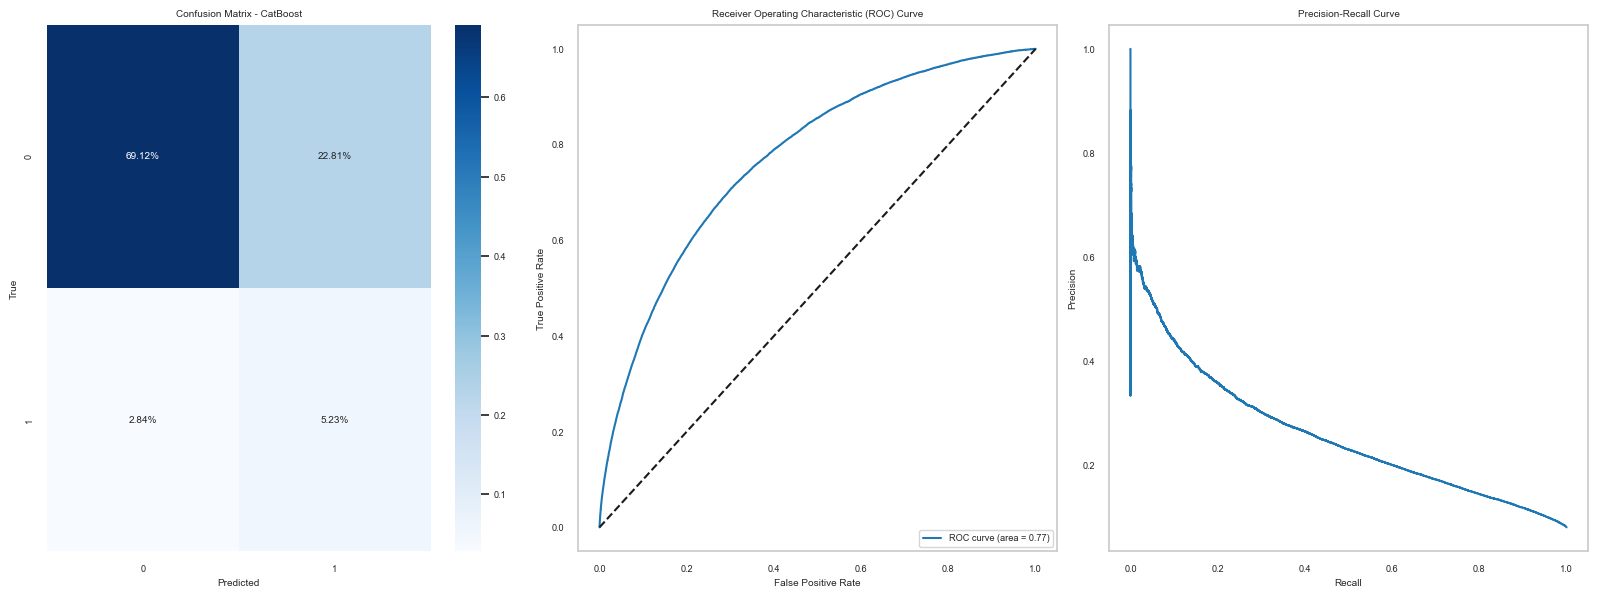


Model: RandomForestClassifier
Overall ROC AUC: 0.7563
Mean Fold ROC AUC: 0.7557 (+/- 0.0026)
95% Confidence Interval: (0.7542, 0.7572)
Coefficient of Variation: 0.0035
Model performance is very stable across folds.


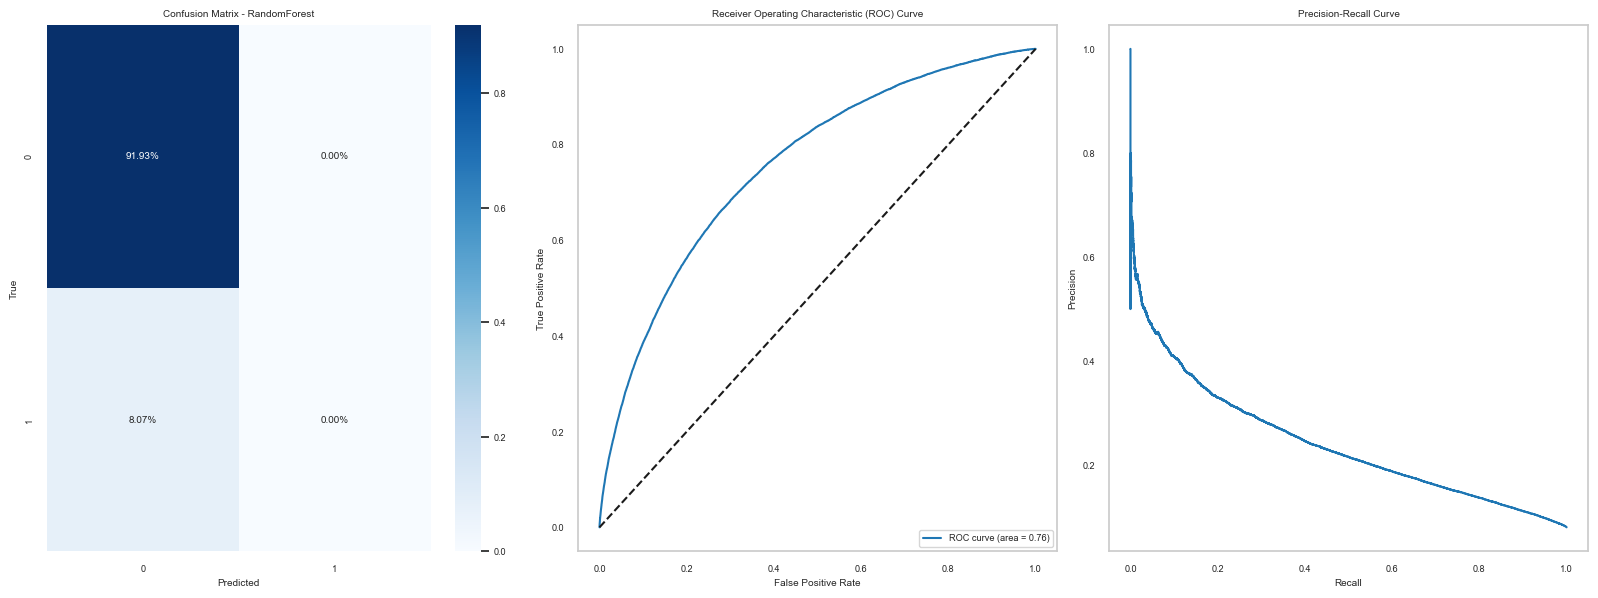

,Model,Score (post-FE),Score (post-Tuning)
0,XGBoost,0.765,0.770
1,LightGBM,0.771,0.773
2,CatBoost,0.769,0.771
3,RandomForest,0.750,0.756


In [54]:
for model_name, model in final_models.items():
    start_time = time.time()
    roc_auc, y_pred, y_pred_proba  = calculate_roc_auc_score(model, X_train, y_train, rskf)
    end_time = time.time()
    training_time = end_time - start_time
    df_performance.loc[df_performance['Model'] == model_name, 'Score (post-Tuning)'] = roc_auc
    export_predictions(model, X_test, test_id, f'{model_name}_post_tuning')
    visualize_performance(y=y_train, y_pred=y_pred, y_pred_proba=y_pred_proba, model_name=model_name)
    print(f'Training time: {training_time}')
df_performance

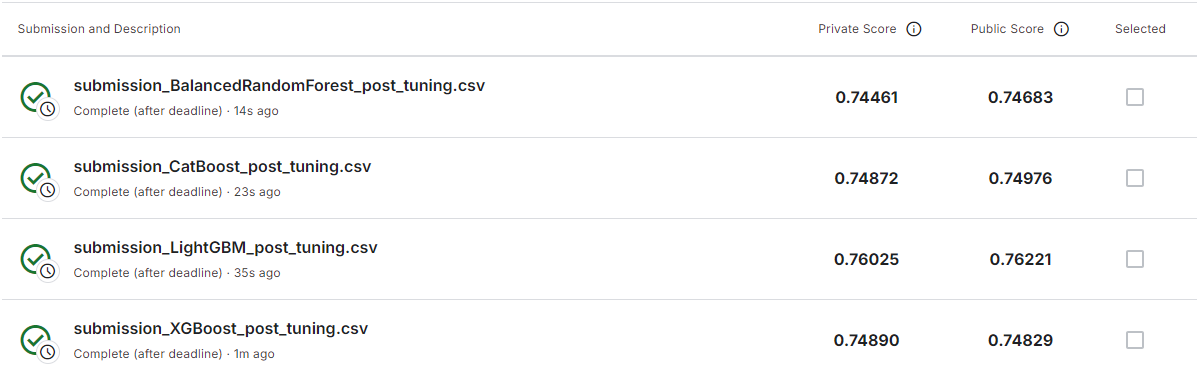

In [55]:
Image('media/post_tuning_score.png')

<div class="results">
    <h3>Model Results</h3>
    <p>Tuned classifiers</p>
    <ol>
        <ul>Hyperparameter had either slight improvements or decrease in train dataset performance</ul>
        <ul>False Positives remains a prevalent issue</ul>
        <ul>LightGBM retains the lead; Additionally, it has significantly reduced its false positives</ul>
        <ul>Balanced Random Forest and CatBoost have the most false positives, comprising of roughly 30% of all instances, but they also have the largest true positive rate</ul>
    </ol>
</div>

## Ensemble methods
We have tuned each model. Let's try out an ensemble method to see if it can produce a better output.
To reduce redundancy and improve model training times, we will not use `LightGBM` since the underlying concept is very similar to `XGBoost`, and the latter performs slightly better on the dataset.

### Voting Classifier
Let's attempt a Voting Classifier ensemble to see if we can get a better operational model.

We will begin without any model-specific weights, giving equal strength to all three models.


Model: VotingClassifier
Overall ROC AUC: 0.7730
Mean Fold ROC AUC: 0.7722 (+/- 0.0024)
95% Confidence Interval: (0.7708, 0.7736)
Coefficient of Variation: 0.0032
Model performance is very stable across folds.


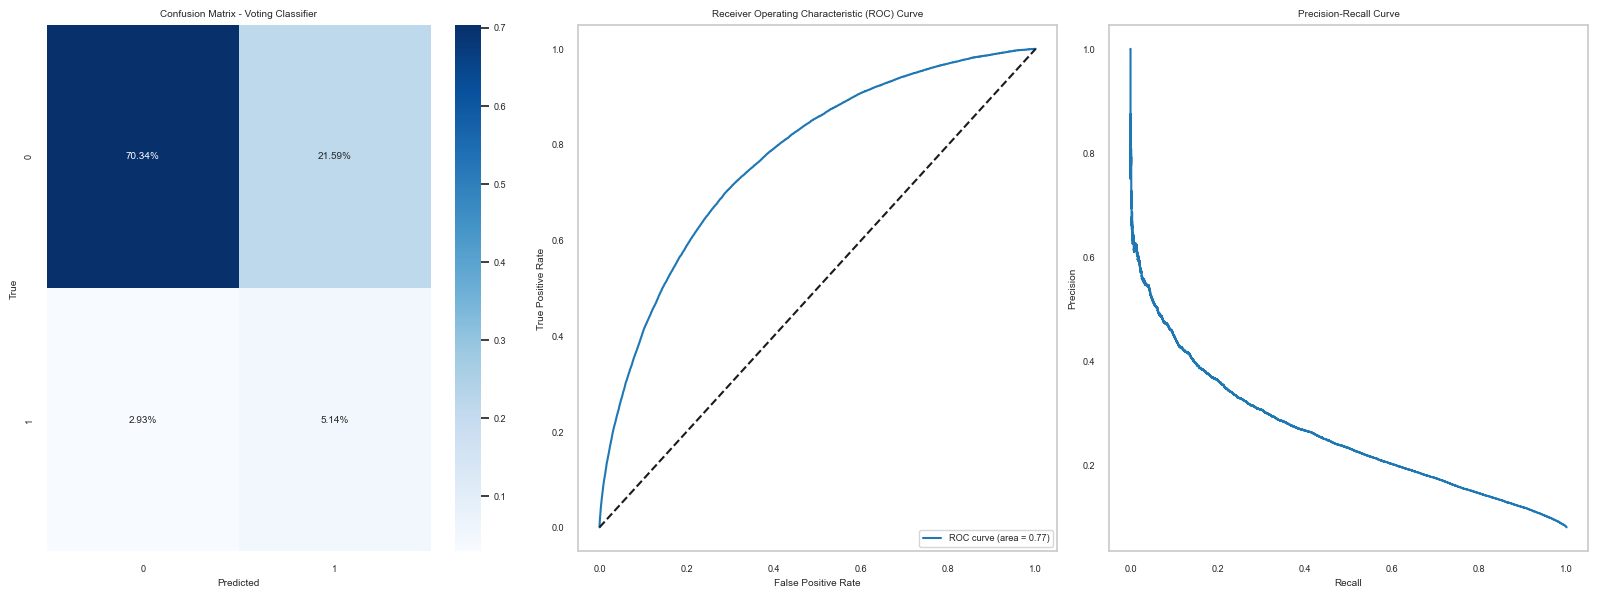

In [56]:
ensemble_voting = VotingClassifier(
    estimators=[
        ('xgb', final_models['LightGBM']),
        ('cat', final_models['CatBoost']),
    ],
    voting='soft'
)

roc_auc, y_pred_vc, y_pred_proba_vc  = calculate_roc_auc_score(ensemble_voting, X_train, y_train, rskf)
export_predictions(ensemble_voting, X_test, test_id, f'_VE')
visualize_performance(y=y_train, y_pred=y_pred_vc, y_pred_proba=y_pred_proba_vc, model_name='Voting Classifier')

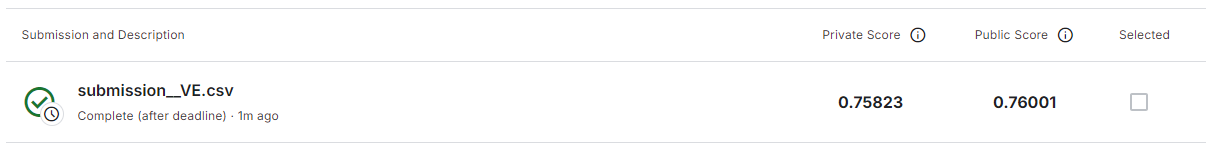

In [57]:
Image('media/VE_score.png')

<div class="results">
    <h3>Model Results</h3>
    <p>Voting Classifier - non-weighted</p>
    <ol>
        <ul>Decent Confusion Matrix performance with the ensemble having sub-20% false positives and identifying 60% of defaults correctly</ul>
        <ul>Similar Public and Private scores to the tuned LightGBM model</ul>
    </ol>
</div>

#### Optimal Weights
Next, let's experiment with a weighted Voting Classifier ensemble, giving more power to the most performant models. We will use optimize the weights using a minimization function.

In [59]:
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

models = []
for model_name, model in final_models.items():
    if model_name not in ['XGBoost', 'RandomForest']:
        models.append(model)
        model.fit(X_train_sub, y_train_sub)

predictions = [model.predict_proba(X_val)[:, 1] for model in models]

starting_values = [1/len(models)] * len(models)
cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
bounds = [(0,1)]*len(models)

res = minimize(negative_auc_roc, starting_values, args=(y_val, *predictions),
            method='SLSQP', bounds=bounds, constraints=cons)

optimized_weights = res.x

for i, weight in enumerate(optimized_weights):
    print(f"Model {i+1} weight: {weight:.4f}")

optimized_auc = -res.fun
print(f"Optimized AUC-ROC: {optimized_auc:.4f}")

del X_train_sub, X_val, y_train_sub, y_val

Model 1 weight: 0.4999
Model 2 weight: 0.5001
Optimized AUC-ROC: 0.7722


It seems that the optimal AUC-ROC score is when both models have equal weight distribution. For that reason, we will maintain the initial `VotingClassifier`.

## Final Models
For the competition and further analysis, we will select the following models:
* Tuned LightGBM model
* Voting Classifier ensemble model

### Feature Importances of the Models
Let's see whether the most important features for the model align with our EDA findings.

In [60]:
selected_models = {
    'Tuned LightGBM': final_models['LightGBM'],
    'Ensemble Voting': ensemble_voting
}

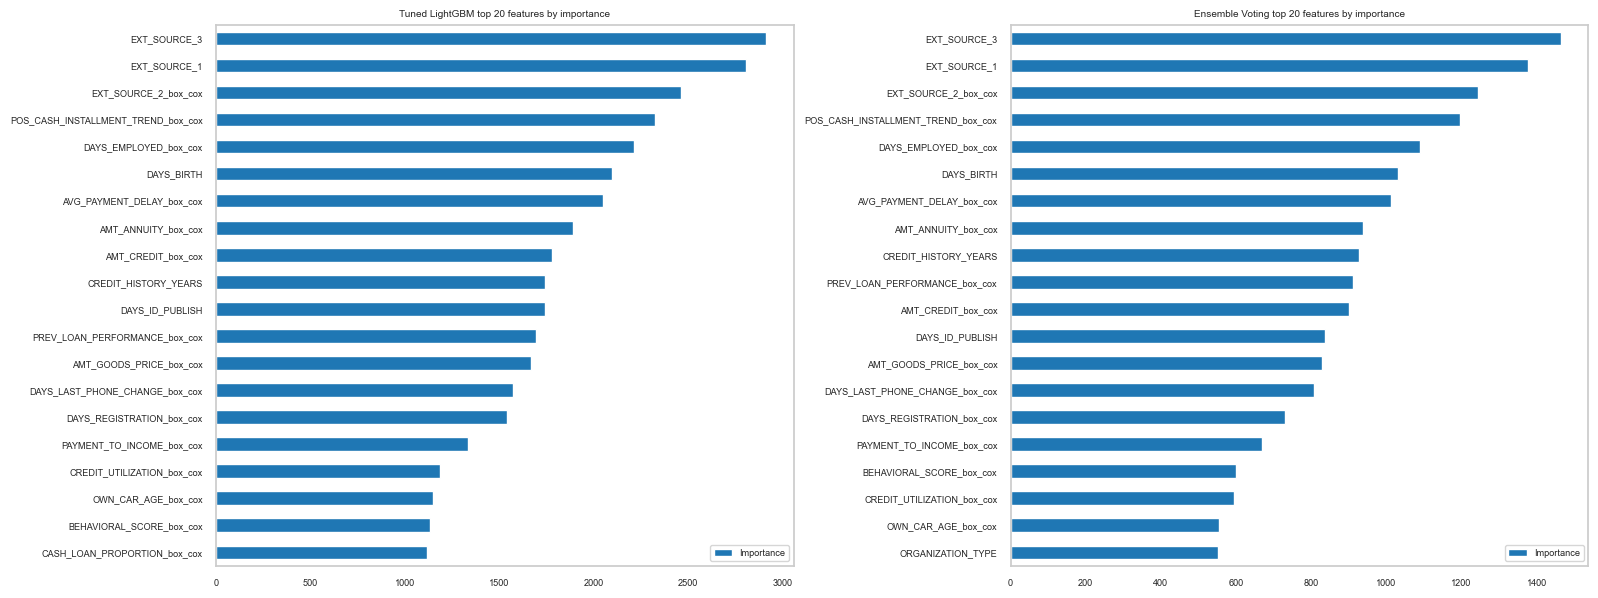

In [61]:
feature_names = X_train.columns.tolist()
plot_feature_importance(selected_models, feature_names, top_n=20)

<div class="results">
    <h3>Model Results</h3>
    <p>Feature Importances</p>
    <ol>
        <ul>The top 6 features are the same for both models</ul>
        <ul>Both models regard the custom variable <code>POS_CASH_INSTALLMENT_TREND</code> as an important feature</ul>
        <ul><code>EXT_SOURCE</code> 3, 2 and 1 are both very important external source features</ul>
        <ul>Employment duration, age and average delay in payments are other very significant features recognized for both models</ul>
    </ol>
</div>

### Probability Distributions
Finally, let's visually assess how well the models managed to differentiate the two categories of customers.

In [62]:
y_pred_proba_ensemble = y_pred_proba_vc
_, _, y_pred_proba_lgbm  = calculate_roc_auc_score(final_models['LightGBM'], X_train, y_train,
                                                   rskf, print_scores=False)

y_proba_preds = {
    'Tuned LightGBM': y_pred_proba_lgbm,
    'Ensemble Voting': y_pred_proba_ensemble
}

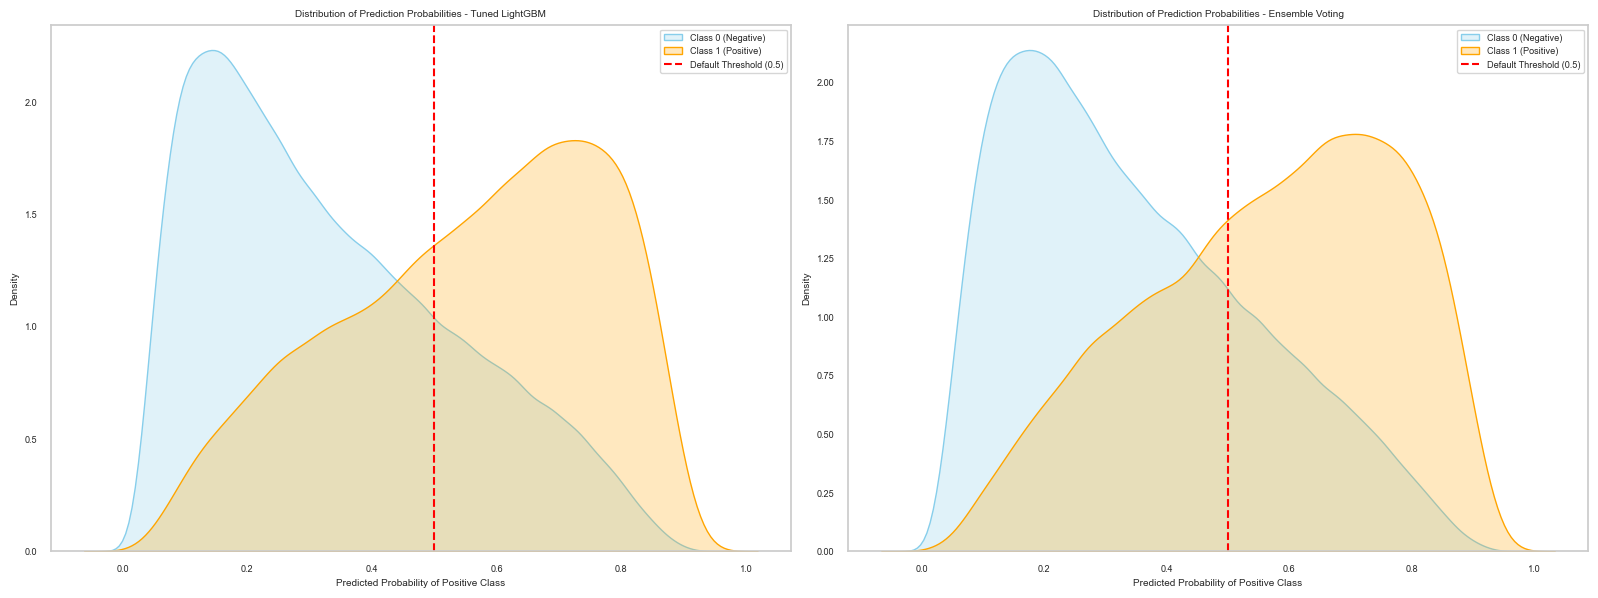

In [63]:
plot_probability_distribution(y_train, y_proba_preds)

<div class="results">
    <h3>Model Results</h3>
    <p>Predicted Probabilities</p>
    <ol>
        <ul>Both models predict very similarly - LightGBM predicts the negative class slightly better</ul>
        <ul>The optimal threshold for differentiating both categories of clients is about 0.4</ul>
    </ol>
</div>

## Model Deployment
With these observations in mind, it seems that the tuned LightGBM model has a slight edge in differentiating the two classes. Let's do the following:
* Export the model
* Retrieve the column names used in training (will be used to align the production inputs to what the model expects)

In [55]:
joblib.dump(final_models['LightGBM'], 'TunedLightGBM.pkl')

['TunedLightGBM.pkl']

In [56]:
cols = X_train.columns
with open('columns.txt', 'w') as f:
    for col in cols:
        f.write(col + '\n')

The model is deployed in Google Cloud. Inputs are provided through HTTP calls:
```cmd
curl -v POST https://example-endpoint.run.app/predict \
-F "client=@http_tests/client.csv" \
-F "bureau_balance=@http_tests/bureau_balance.csv" \
-F "bureau=@http_tests/bureau.csv" \
-F "previous_application=@http_tests/previous_application.csv" \
-F "credit_card_balance=@http_tests/credit_card_balance.csv" \
-F "installments_payments=@http_tests/installments_payments.csv" \
-F "pos_cash_balance=@http_tests/pos_cash_balance.csv" \
-H "Authorization: Bearer YOUR_TOKEN_HERE"
```

* All datasets found in the initial project dataset are considered in generating predictions
* The program creates new features, encodes, scales and aligns the newly created dataset to the shape that the model expects
* Predictions are returned as .json output
* Alongside the prediction of a default, the client is categorized:
  * Prediction <= 0.3 - Low risk
  * Prediction > 0.3 - Moderate risk
  * Prediction > 0.7 - High risk

# Summary
## Findings
The Home Credit Risk Group dataset had opportunities for data imputation, reduction, transformation and new features' creation using data from other datasets. The data for binary classification was imbalanced, with less than 10% of clients defaulting. During the study, we trained 4 separate ML models, all of which support missing data to maintain feature interaction. `LightGBM` model and a `VotingClassifier` ensemble provided the best area under the ROC Curve score, while maintaining moderate false positives.

External scores from other companies and some custom-made features have proven to be useful for the final models. Additionally, the client's age, employment duration and delays in payments provided strong predictive power.

The tuned `LightGBM` model was deployed to Google Cloud and supports HTTP-based inputs to predict credit risk for new clients. The model returns a probability of a default and a risk categorization.

## Considerations
* Entirety of the dataset (Around 70 of features had missing values)
* Logic of the train-test split and potential test dataset bias (even using cross validation, train performance was slightly better)
* Recency of data (Dataset was published 6 years ago, credit risk behaviors might've changed)
* Dataset origin (EU-based)

## Improvements for Future Studies
* Increase Optuna trials
* Test model performance with complete data (imputation or instances / features removal)
* Using complete data, test other models